# Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

datasets: https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa

github link: https://github.com/francodarvas/time_series/blob/main/Proyecto_03_ST_Franco_Darvas.ipynb

# SETUP

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings;warnings.simplefilter('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

#fx
def adfuller_test(flujo):
    result = adfuller(flujo)
    labels = ['ADF Test Statistic','p-value','#Rezagos usados','Número de observaciones']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
      print("Se rechaza la hipótesis nula. La serie de tiempo es estacionaria")
    else:
      print("Poca evidencia en contra de la hipótesis nula. La serie de tiempo NO es estacionaria")

def evaluar_modelo(y_pred, y_true, model):

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    dataf = pd.DataFrame({
        "Modelo": model,
        "RMSE":[RMSE]
    })
    return dataf

def plot_modelo(train,test,pred) :
    fig, (ax1,ax2) = plt.subplots(2,figsize=(18,8))

    ax1.plot(train, label='Train')
    ax1.plot(test , label='Test')
    ax1.plot(pred, label='Forecast')
    ax1.legend(loc="upper right")

    ax2.plot(test, label='Test')
    ax2.plot(pred, label='Forecast')
    ax2.legend(loc="upper right")

    fig.suptitle("Train - Test - Forecast", fontsize=20) 



Importing plotly failed. Interactive plots will not work.


In [2]:
data_2014 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2014.csv', sep =',')
data_2015 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2015.csv', sep =',')
data_2016 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2016.csv', sep =',')
data_2017 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2017.csv', sep =',')
data_2018 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2018.csv', sep =',')
data_2019 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2019.csv', sep =',')
data_2020 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2020.csv', sep =',')

# EDA

## Informacion y primeras filas

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


In [10]:
 # Tamaño de los datasets
print(data_2017.size)
print(data_2018.size)
print(data_2019.size)

13726450
13759080
8121530


## Tipos de variables

In [11]:
# Como los 3 datasets tienen las mismas variables, analizamos solo en el del 2017 cuales variables
# son categoricas y cuales numericas.

var_num = []
var_cat = []

for i in data_2017.columns:
  if data_2017.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables de tipo categoricas: {var_cat}")
print(f"Variables de tipo numericas: {var_num}")

Variables de tipo categoricas: ['fecha', 'dia', 'estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']
Variables de tipo numericas: ['periodo', 'hora_inicio', 'hora_fin', 'cantidad_pasos']


Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

## Distribuciones de Variables Categoricas

In [12]:
var_cat = ['estacion', 'sentido', 'tipo_vehiculo', 'forma_pago']

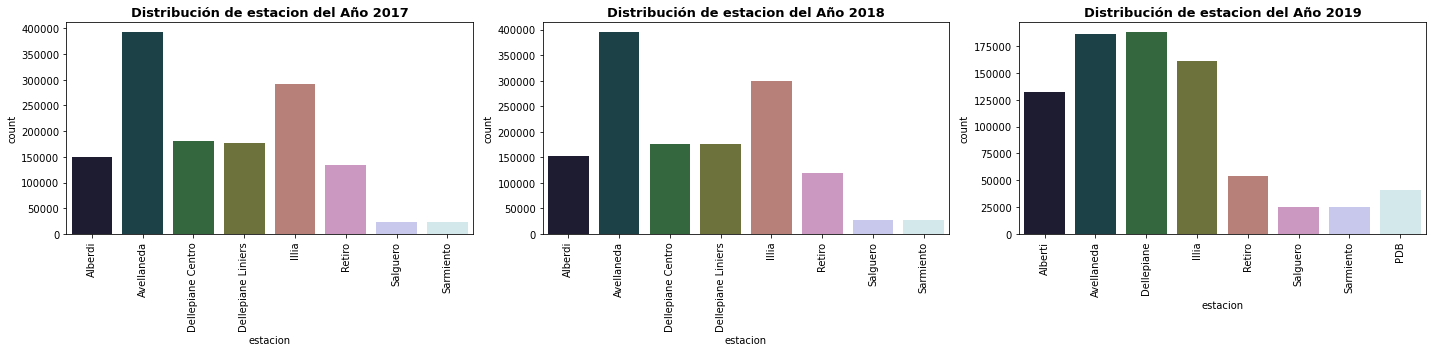

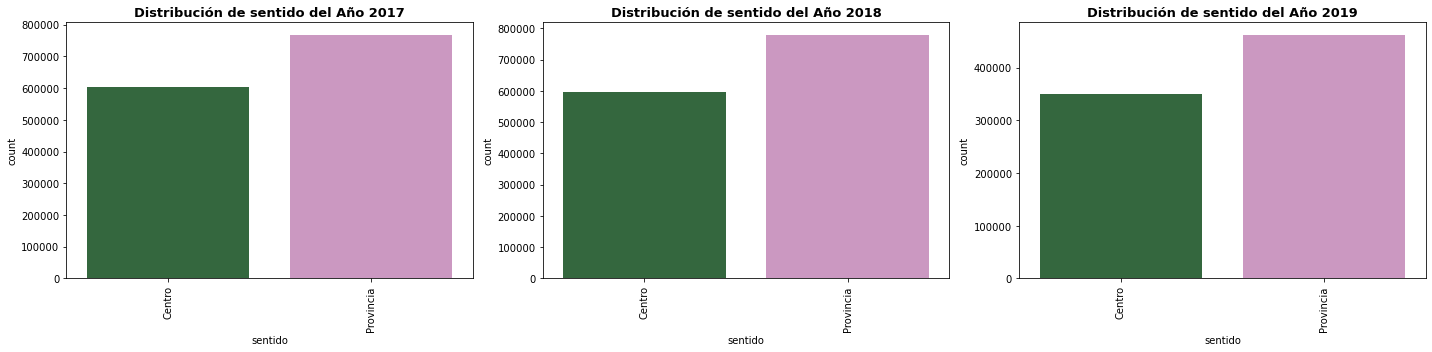

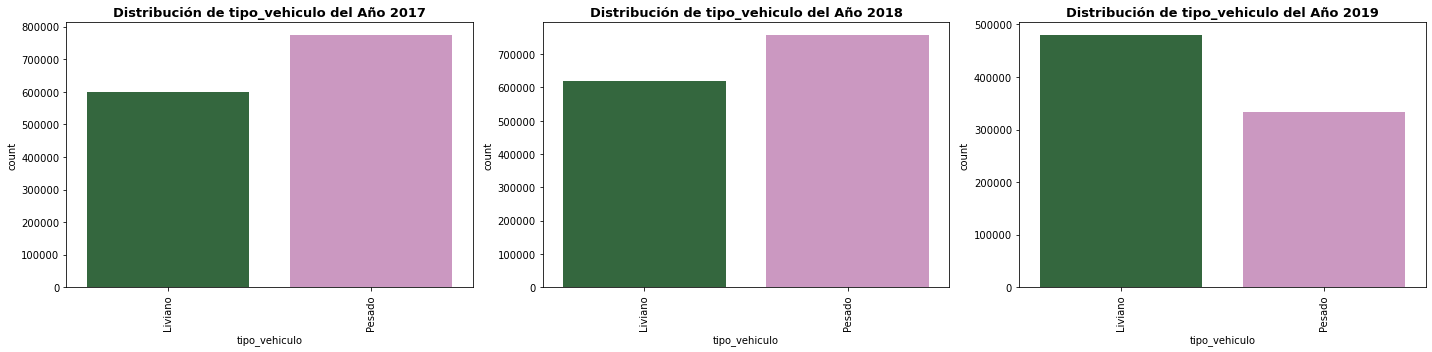

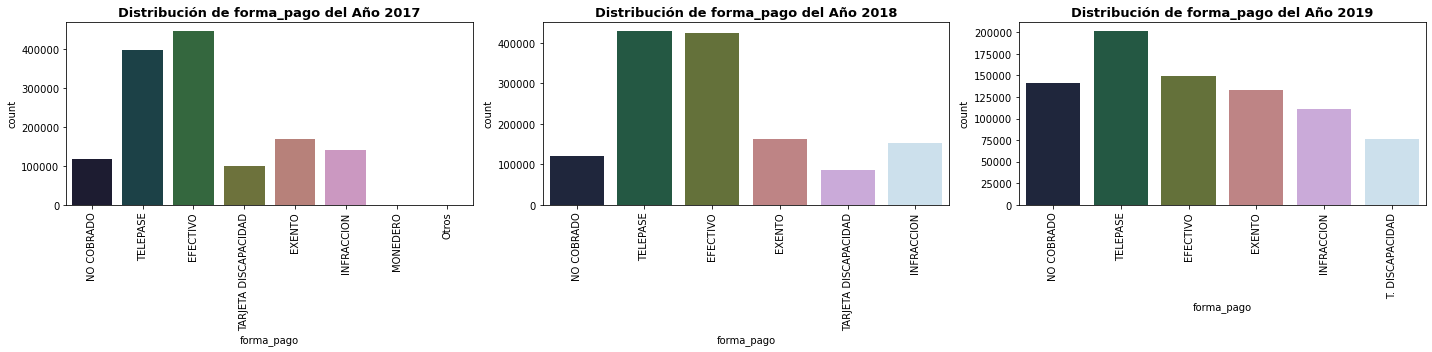

In [13]:
for cat in var_cat:
      plt.figure(figsize=(20,5))
      plt.subplot(1,3,1)
      sns.countplot(data_2017[cat], palette='cubehelix')
      plt.title(f'Distribución de {cat} del Año 2017', size=13, fontweight='bold')
      plt.xticks(rotation=90, size=10)
      plt.subplot(1,3,2)
      sns.countplot(data_2018[cat], palette='cubehelix')
      plt.title(f'Distribución de {cat} del Año 2018', size=13, fontweight='bold')
      plt.xticks(rotation=90, size=10)
      plt.subplot(1,3,3)
      sns.countplot(data_2019[cat], palette='cubehelix')
      plt.title(f'Distribución de {cat} del Año 2019', size=13, fontweight='bold')
      plt.xticks(rotation=90, size=10)
      plt.tight_layout()

## Seleccion

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [14]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [15]:
# Calculo de los nulls
dataset.isna().sum()

fecha             0
hora_fin          0
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
dtype: int64

In [16]:
#Calculo de principales estadisticos del target
dataset.cantidad_pasos.describe()

count    238869.000000
mean        200.384232
std         403.246904
min           1.000000
25%           2.000000
50%          11.000000
75%         104.000000
max        2416.000000
Name: cantidad_pasos, dtype: float64

In [17]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

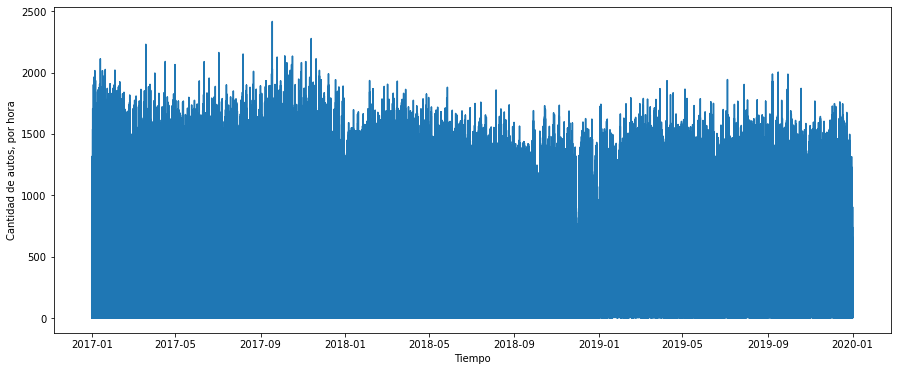

In [18]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [19]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

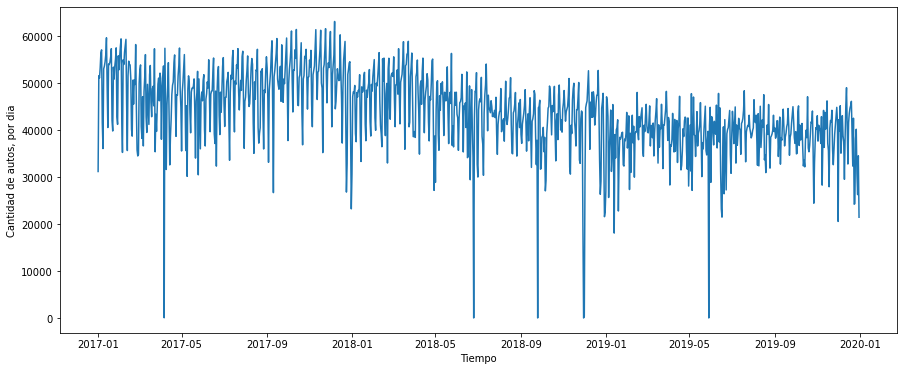

In [20]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## Outliers

In [21]:
diario.cantidad_pasos.describe([0.01,0.05, 0.25, 0.5, 0.75, 0.90, 0.95,0.99])

count     1095.000000
mean     43712.859361
std       8192.736927
min          0.000000
1%       21553.600000
5%       31194.200000
25%      39061.500000
50%      43761.000000
75%      49498.000000
90%      53738.200000
95%      56016.100000
99%      59427.380000
max      63127.000000
Name: cantidad_pasos, dtype: float64

Text(0.5, 1.0, 'Boxplot de cantidad de pasos diarios')

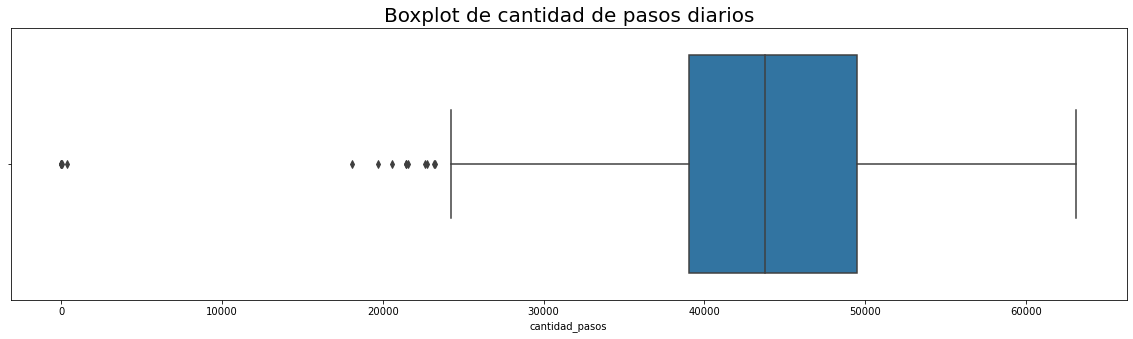

In [22]:
plt.figure(figsize=(20,5))
sns.boxplot(diario.cantidad_pasos)
plt.title("Boxplot de cantidad de pasos diarios", fontsize=20)

Tomamos como dias realmente atipicos aquellos que estan cercanos a 0 cantidad de pasos.

In [23]:
atipicos = diario[diario.cantidad_pasos < 10000]
atipicos

cantidad_pasos
fecha                     
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-30               0
2018-12-01             350
2019-05-29               0

Informacion auxiliar para entender los valores atipicos:

Vamos a evaluar fecha por fecha que fue lo que sucedio y asi discernir si fue un suceso preciso o fue un error a la hora de tomar los datos.

* 2017-04-06: Huelga general. (https://www.rfi.fr/es/americas/20170406-primera-huelga-general-en-argentina-de-la-era-macri)
* 2018-06-25: Huelga general. (https://www.france24.com/es/20180625-argentina-huelga-general-mauricio-macri)
* 2018-09-25: Huelga general. (https://www.france24.com/es/20180925-argentina-protestas-macri-huelga-general
* 2018-11-30: G20 (https://www.infobae.com/politica/2018/10/30/)el-gobierno-decreto-feriado-el-30-de-noviembre-en-la-ciudad-de-buenos-aires-por-la-cumbre-del-g20/)
* 2018-12-01: G20 (https://www.argentina.gob.ar/g20/g20-2018)
* 2019-05-29:  Huelga general. (https://elpais.com/internacional/2019/05/29/argentina/1559153842_024679.html)

En todas las fechas hubo sucesos que justifican el valor atipico.

In [24]:
# Reemplazamos esas fechas por NaN

diario[diario.cantidad_pasos < 10000] = np.nan

## Valores Faltantes

In [25]:
print(diario.isna().sum())
diario = diario.interpolate(method="nearest")
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


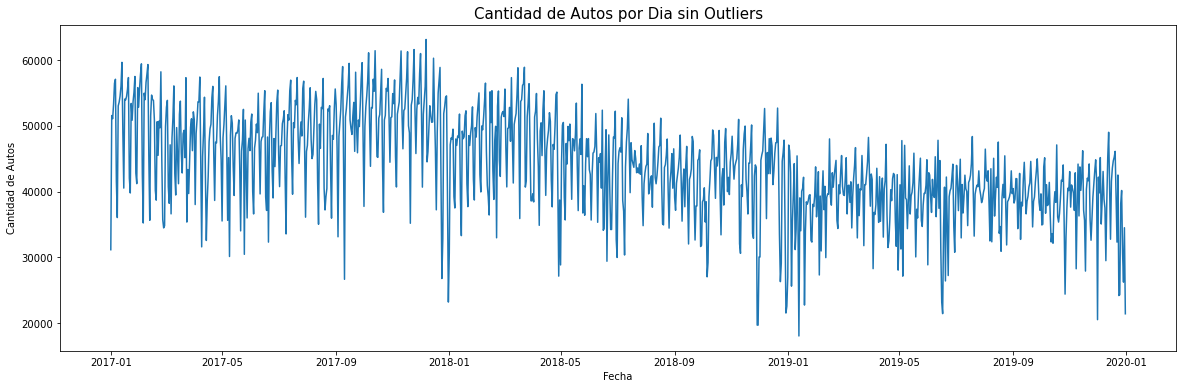

In [26]:
plt.figure(figsize=(20,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos')
plt.title('Cantidad de Autos por Dia sin Outliers', fontsize=15)
plt.show()

In [27]:
# Verificamos que la serie de tiempo este completa:
(diario.index == pd.date_range(start=diario.index.min(), end=diario.index.max(), freq=diario.index.freq)).all()

True

## Resample Semanal

In [28]:
semanal = diario.copy()
semanal.reset_index(inplace=True)

In [29]:
semanal = semanal.resample('W', on='fecha').sum()
semanal.head()

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-08        347212.0
2017-01-15        366413.0
2017-01-22        357215.0
2017-01-29        354581.0

In [30]:
semanal.cantidad_pasos.describe()

count       158.000000
mean     304306.816456
std       46092.962139
min       31183.000000
25%      276604.500000
50%      307243.000000
75%      335333.000000
max      377832.000000
Name: cantidad_pasos, dtype: float64

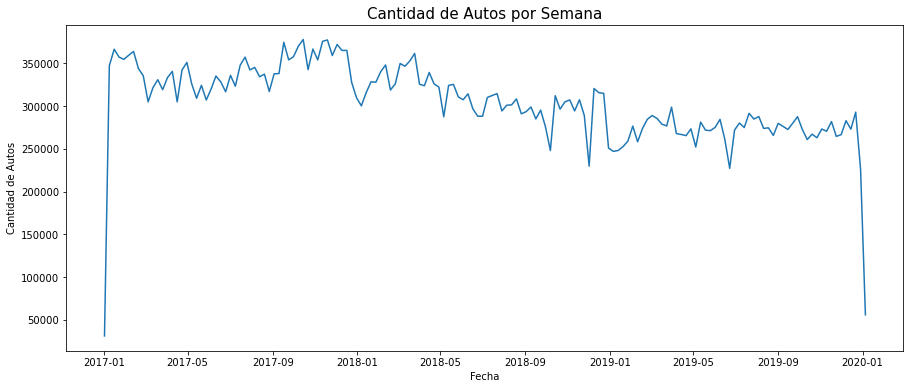

In [31]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos')
plt.title('Cantidad de Autos por Semana', fontsize=15)
plt.show()

In [32]:
# Los valores minimos se deben a que faltan dias para completar el valor semanal, por eso 
# vamos a convertirlos en NaN y luego utilizar la funcion interpolate como hicimos anteriormente.
semanal.cantidad_pasos[semanal.cantidad_pasos < 150000] = np.nan

In [33]:
print(semanal.isna().sum())
semanal.cantidad_pasos.interpolate(method="pad",inplace=True)
print(semanal.isna().sum())
semanal.cantidad_pasos.fillna(value=347212, inplace=True)
print(semanal.isna().sum())

cantidad_pasos    2
dtype: int64
cantidad_pasos    1
dtype: int64
cantidad_pasos    0
dtype: int64


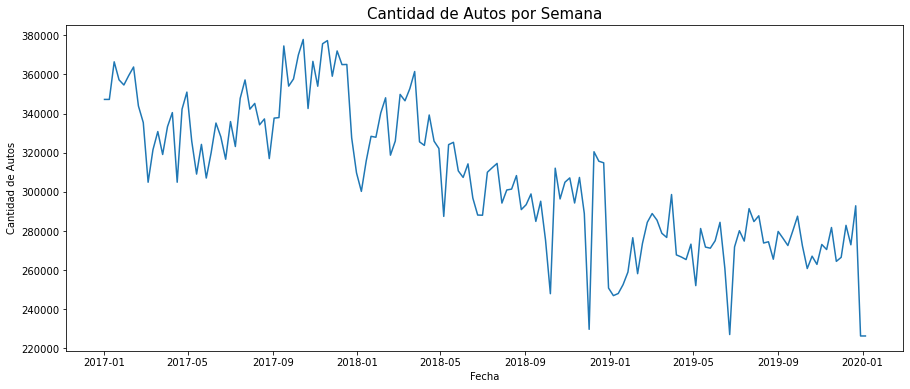

In [34]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos')
plt.title('Cantidad de Autos por Semana', fontsize=15)
plt.show()

## Componentes
tendencia + estacionalidad + ciclos + ruido


### Tendencia Lineal

In [35]:
media_movil = diario.rolling(
    window=365,
    center=True,
    min_periods= 183
).mean()

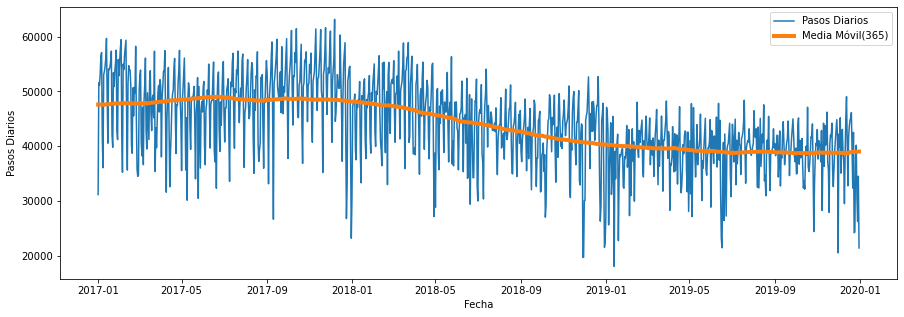

In [36]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Pasos Diarios')
plt.plot(media_movil, lw = 4, label = 'Media Móvil(365)')
plt.xlabel('Fecha')
plt.ylabel('Pasos Diarios')
plt.legend()
plt.show()

In [37]:
# Se agrega una columna con las fechas en formato numerico para poder hacer la regresion lineal
diario['fecha_numeros'] = diario.index.map(datetime.datetime.toordinal)
diario.head()

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-01         31183.0         736330
2017-01-02         51568.0         736331
2017-01-03         51093.0         736332
2017-01-04         53332.0         736333
2017-01-05         56486.0         736334

In [38]:
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

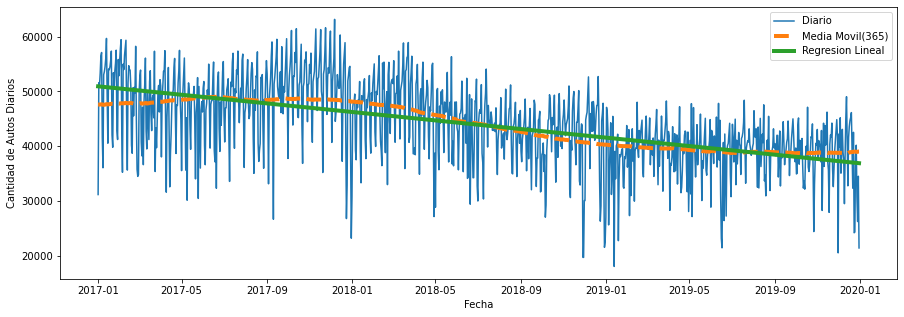

In [39]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(media_movil, ls = '--', lw = 4, label = 'Media Movil(365)')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresion Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos Diarios')
plt.legend()
plt.show()

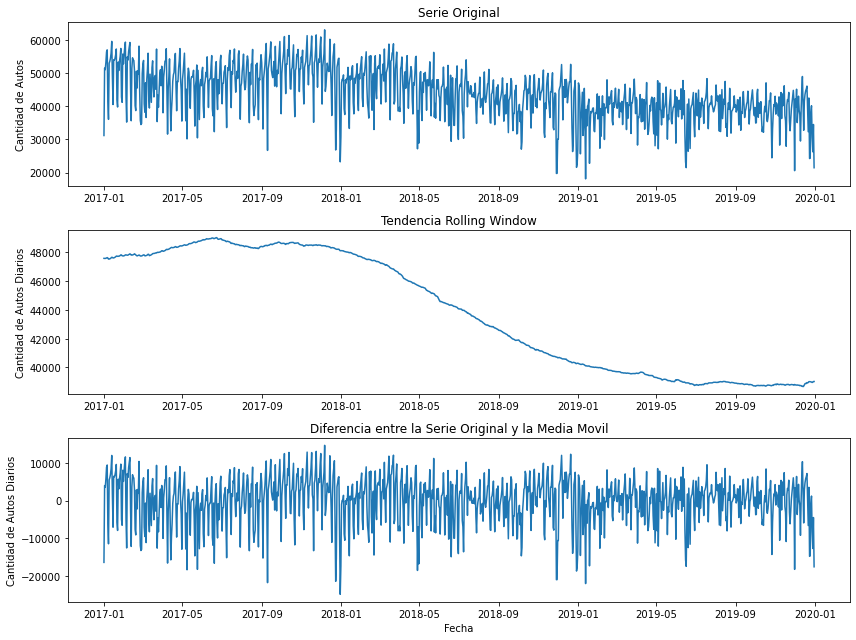

In [40]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de Autos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(media_movil)
plt.ylabel('Cantidad de Autos Diarios')

plt.subplot(3,1,3)
plt.title('Diferencia entre la Serie Original y la Media Movil')
plt.plot(diario.index, diario.cantidad_pasos-media_movil.cantidad_pasos)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Autos Diarios')

plt.tight_layout()
plt.show()

In [41]:
detrended = diario.cantidad_pasos-media_movil.cantidad_pasos
detrended =  pd.DataFrame(detrended)

In [42]:
diario.drop(columns = ['fecha_numeros'], inplace = True)
diario.head()

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0

In [43]:
data_2017

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2017  2017-01-01            0         1  Domingo    Alberdi   
1           2017  2017-01-01            0         1  Domingo    Alberdi   
2           2017  2017-01-01            1         2  Domingo    Alberdi   
3           2017  2017-01-01            1         2  Domingo    Alberdi   
4           2017  2017-01-01            1         2  Domingo    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1372640     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo  Sarmiento   
1372644     2017  2017-12-31           23         0  Domingo  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              25  
1           Centro       Liviano    TELEPASE               7  
2           Centro       Liviano  NO COBRADO               5  
3           Centro       Liviano    EFECTIVO               2  
4           Centro       Liviano    EFECTIVO              94  
...            ...           ...         ...             ...  
1372640  Provincia       Liviano  NO COBRADO               3  
1372641  Provincia       Liviano    TELEPASE              10  
1372642  Provincia        Pesado    TELEPASE               1  
1372643  Provincia       Liviano  NO COBRADO               1  
1372644  Provincia       Liviano    TELEPASE               4  

[1372645 rows x 10 columns]

In [44]:
# Buscamos la razon de la tendencia negativa y vemos que si bien en el 2019 la cantidad de entradas son menos
# no justifica la tendencia negativa entre el 2017 y 2018

print(data_2017.size)
print(data_2018.size)
print(data_2019.size)

13726450
13759080
8121530


In [45]:
formas_2017 = pd.DataFrame(data_2017.forma_pago.value_counts())
formas_2018 = pd.DataFrame(data_2018.forma_pago.value_counts())
formas_2019 = pd.DataFrame(data_2019.forma_pago.value_counts())

In [46]:
print(formas_2017.columns)
print(formas_2018.columns)
print(formas_2019.columns)

Index(['forma_pago'], dtype='object')
Index(['forma_pago'], dtype='object')
Index(['forma_pago'], dtype='object')


In [47]:
formas_2017.rename(columns = {'forma_pago':'forma_pago_2017'}, inplace= True)
formas_2017 = formas_2017.T

formas_2018.rename(columns = {'forma_pago':'forma_pago_2018'}, inplace= True)
formas_2018 = formas_2018.T

formas_2019.rename(columns = {'forma_pago':'forma_pago_2019'}, inplace= True)
formas_2019 = formas_2019.T

In [48]:
cambio_forma_pago = pd.concat([formas_2017, formas_2018, formas_2019])

In [49]:
cambio_forma_pago

EFECTIVO  TELEPASE  EXENTO  INFRACCION  NO COBRADO  \
forma_pago_2017    447203    397420  169889      140275      117730   
forma_pago_2018    423633    429053  162103      153331      121440   
forma_pago_2019    149340    201388  132716      111428      141280   

                 TARJETA DISCAPACIDAD  MONEDERO  Otros  T. DISCAPACIDAD  
forma_pago_2017              100106.0      14.0    8.0              NaN  
forma_pago_2018               86348.0       NaN    NaN              NaN  
forma_pago_2019                   NaN       NaN    NaN          76001.0

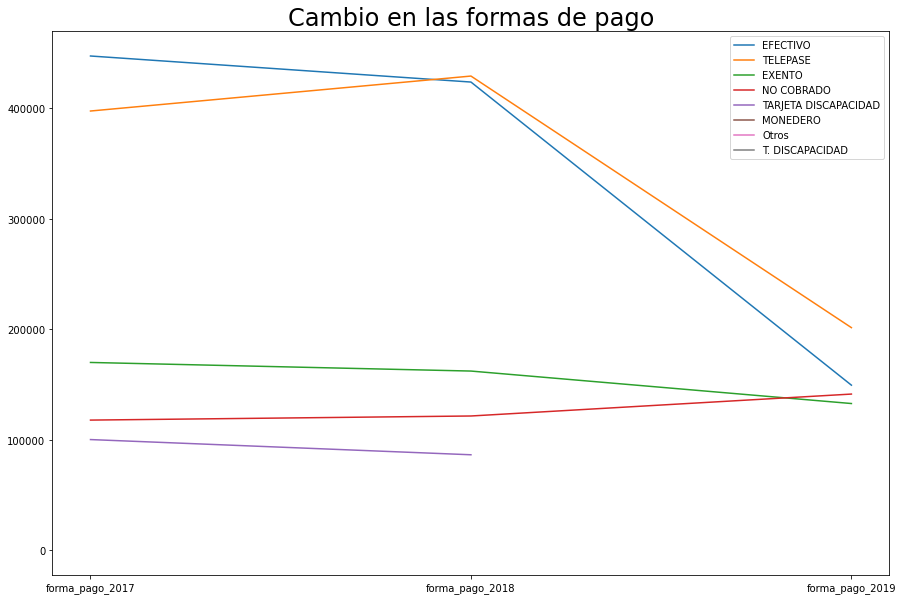

In [50]:
plt.figure(figsize = (15,10))

plt.title("Cambio en las formas de pago", fontsize=24)
plt.plot(cambio_forma_pago.EFECTIVO, label="EFECTIVO")
plt.plot(cambio_forma_pago.TELEPASE, label="TELEPASE")
plt.plot(cambio_forma_pago.EXENTO, label="EXENTO")
plt.plot(cambio_forma_pago["NO COBRADO"], label="NO COBRADO")
plt.plot(cambio_forma_pago["TARJETA DISCAPACIDAD"], label="TARJETA DISCAPACIDAD")
plt.plot(cambio_forma_pago.MONEDERO, label="MONEDERO")
plt.plot(cambio_forma_pago.Otros, label="Otros")
plt.plot(cambio_forma_pago["T. DISCAPACIDAD"], label="T. DISCAPACIDAD")

plt.legend()
plt.show()

Vemos que en parte la tendencia negativa de los pagos en efectivo puede deberse a la una mayor adopcion del metodo de pago "TELEPASE", como tambien un aumento en "NO COBRADO" e "INFRACCION". Esto podria justificar la tendencia negativa que hay del año 2017 al 2020.

### Estacionalidad

In [51]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

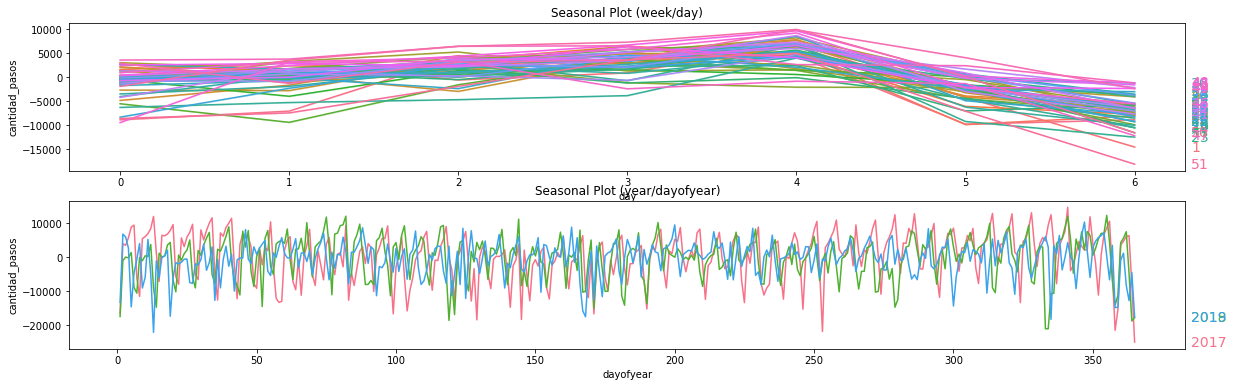

In [52]:
X = detrended.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 6))
seasonal_plot(X, y="cantidad_pasos", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="cantidad_pasos", period="year", freq="dayofyear", ax=ax1);
plt.tight_layout

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

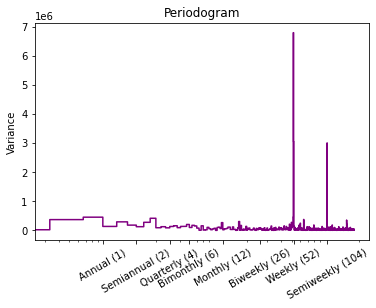

In [53]:
plot_periodogram(detrended.cantidad_pasos)

Tanto el periodograma como el grafico estacional muestran una fuerte estacionalidad semanal, y una debil estacionalidad anual.

In [54]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="W", order=1)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=detrended.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

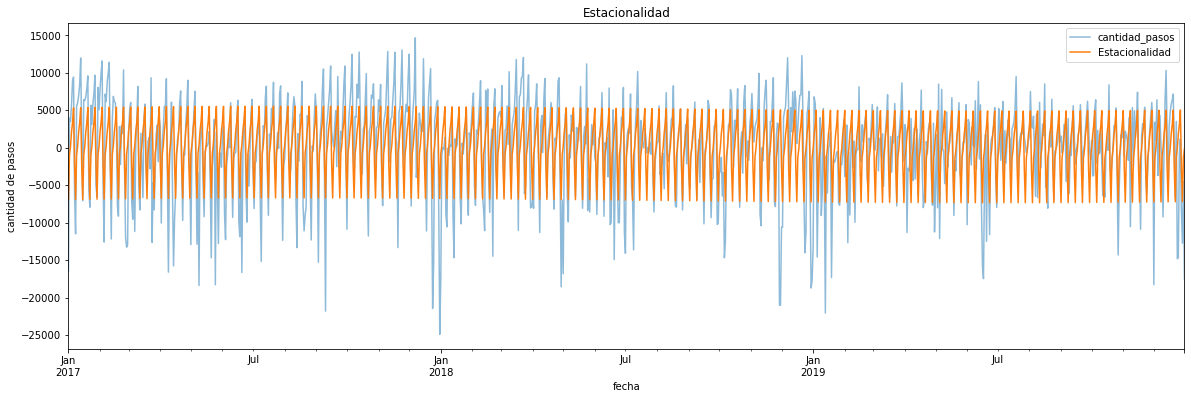

In [55]:
y = detrended["cantidad_pasos"]

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)

plt.figure(figsize=(20,6))
ax = y.plot( alpha=0.5, title="Estacionalidad", ylabel="cantidad de pasos")
ax = y_pred.plot(ax=ax, label="Estacionalidad")
ax.legend();

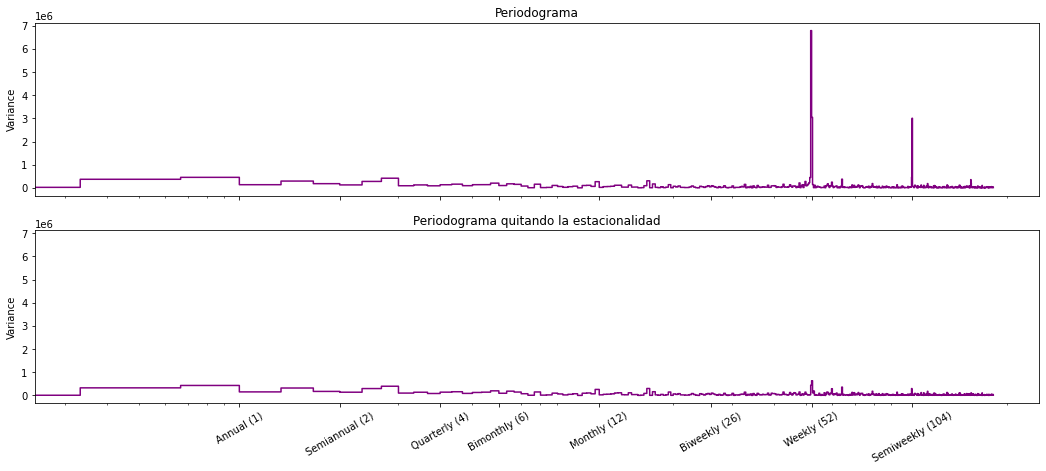

In [56]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(18, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Periodograma")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Periodograma quitando la estacionalidad");

Al ver que ahora en el periodograma no hay grandes valores en la varianza de la esacionalidad, asumimos que capturamos la variacion estacional correctamente.

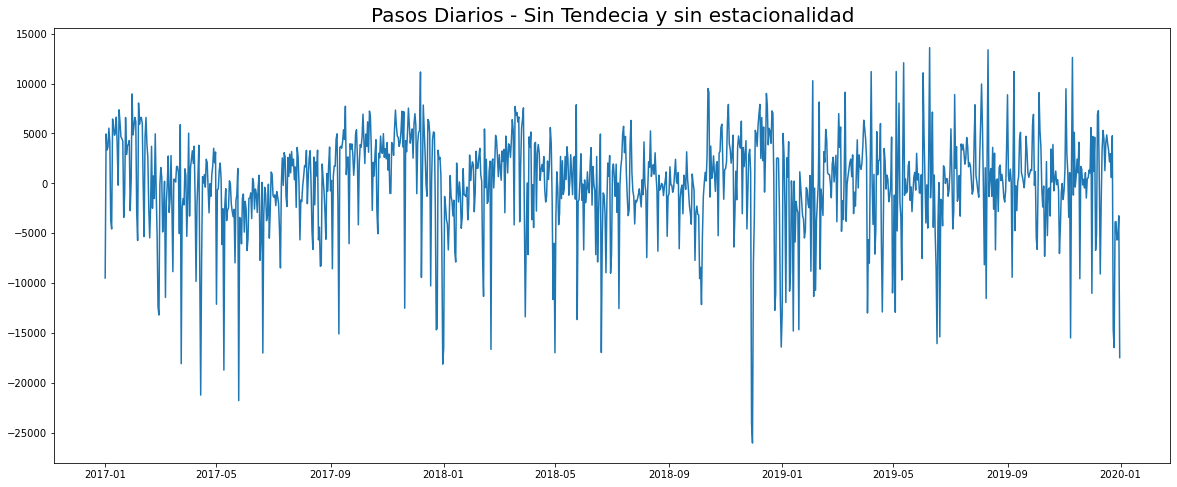

In [57]:
deseason = y_deseason


plt.figure(figsize=(20,8))
plt.title("Pasos Diarios - Sin Tendecia y sin estacionalidad", fontsize=20)
plt.plot(deseason)

El grafico de arriba muestra lo que seria el ruido de la serie de tiempo.

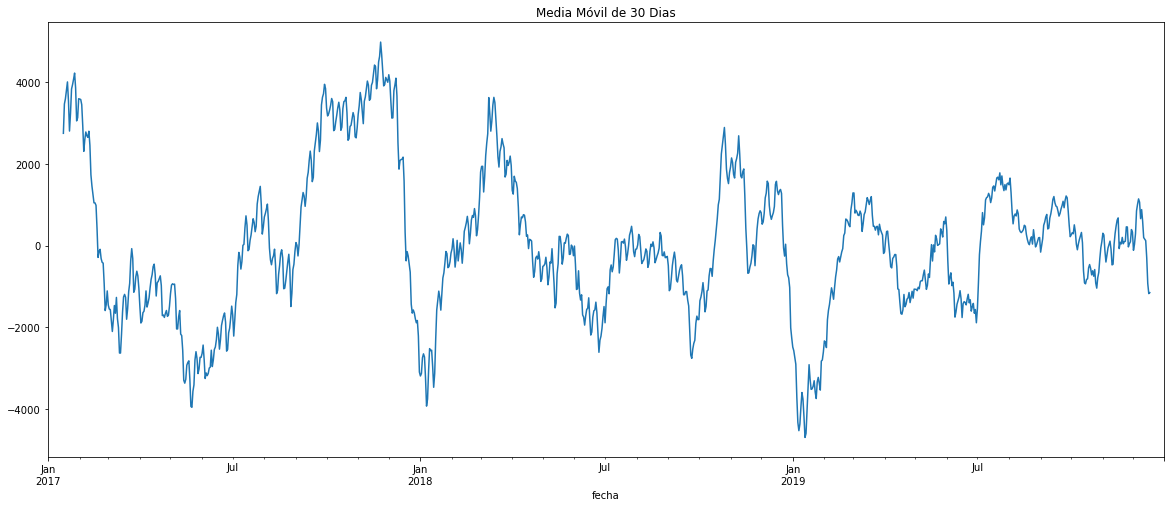

In [58]:
y_ma = y.rolling(30, center=True).mean()

# Plot
plt.figure(figsize=(20,8))
ax = y_ma.plot()
ax.set_title("Media Móvil de 30 Dias");

### Descomposicion de la serie
Utilizando statsmodels

In [59]:
descomposicion_diario = sm.tsa.seasonal_decompose(diario['cantidad_pasos'], model='additive')
trend_diario = descomposicion_diario.trend
seasonal_diario = descomposicion_diario.seasonal
residual_diario = descomposicion_diario.resid

descomposicion_semanal = sm.tsa.seasonal_decompose(semanal['cantidad_pasos'], model='additive')
trend_semanal = descomposicion_semanal.trend
seasonal_semanal = descomposicion_semanal.seasonal
residual_semanal = descomposicion_semanal.resid

In [60]:
def plot_descomp(original, trend, season, residual):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(18,8), sharex=True)

    ax1.plot(original, label='Original')
    ax1.legend(loc="lower left")

    ax2.plot(trend, label='Media Movil')
    ax2.legend(loc="lower left")

    ax3.plot(season, label='Estacionalidad')
    ax3.legend(loc="lower left")

    ax4.plot(residual, label='Ruido')
    ax4.legend(loc="lower left")

    fig.suptitle("Descomposicion de la Serie de Tiempo", fontsize=20)

def plot_resi(residual):

    plt.figure(figsize = (6,4))
    sns.histplot(data=residual, stat='density', kde=True, color='blue', alpha=0.2)
    plt.title('Distribucion del Ruido', fontsize=16)
    plt.show()

#### Diario

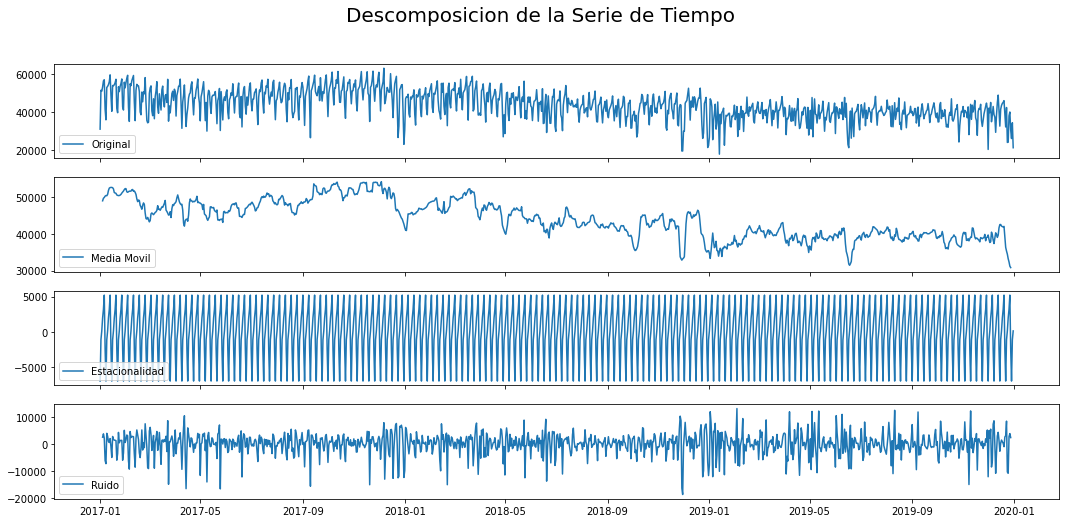

In [61]:
plot_descomp(diario.cantidad_pasos,trend_diario,seasonal_diario, residual_diario)

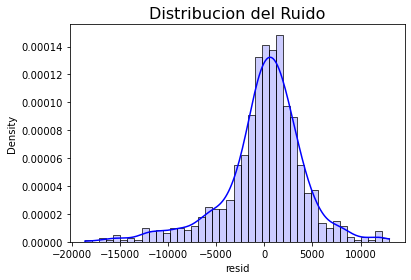

In [62]:
plot_resi(residual_diario)

#### Semanal

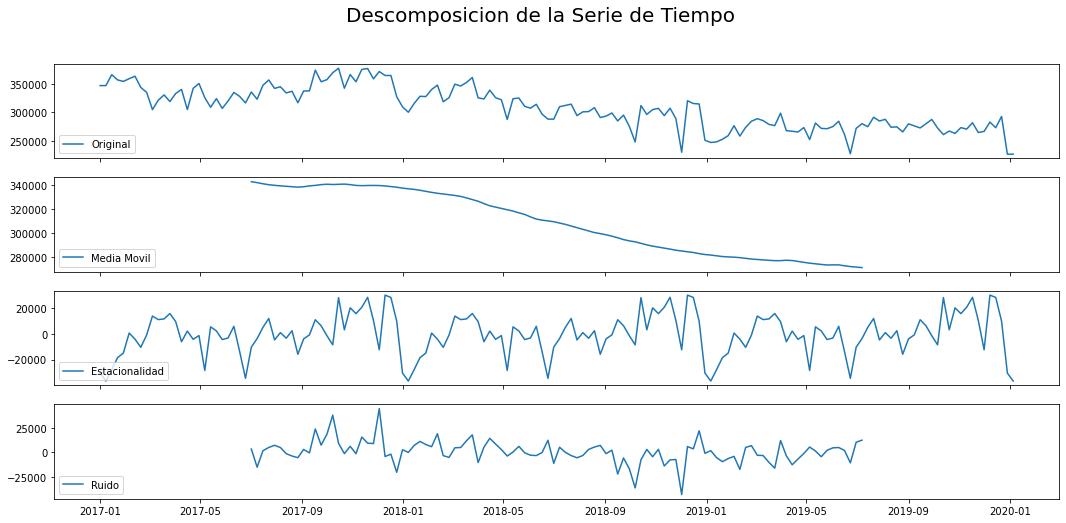

In [63]:
plot_descomp(semanal.cantidad_pasos, trend_semanal, seasonal_semanal, residual_semanal)

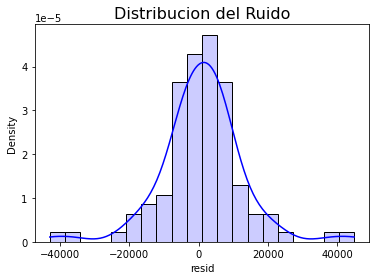

In [64]:
plot_resi(residual_semanal)

## Separacion Test y Train

In [65]:
# El periodo a predecir es el ultimo trimestre del 2019, es decir desde el 1/10/2019

semanal.reset_index('fecha', inplace=True)
diario.reset_index('fecha', inplace=True)

In [66]:
train_diario = diario.loc[(diario['fecha'] < '2019-10-01')]
test_diario = diario.loc[(diario['fecha'] >= '2019-10-01')]

train_semanal = semanal.loc[(semanal['fecha'] < '2019-10-01')]
test_semanal = semanal.loc[(semanal['fecha'] >= '2019-10-01')]

# Modelos Predictivos

La informacion que utilizan los modelos son las fechas y un target, que en este caso es la cantidad de pasos de vehiculos que hay en la estacion Illia, con el pago en efectivo. A su vez los modelos tambien utilizan las componentes que analizamos anteriormente las cuales son la tendencia, la estacionalidad, los ciclos y el ruido.

La metrica a utilizar es el RMSE. Este es el error cuadratico medio y representa a la raíz cuadrada de la distancia cuadrada promedio entre el valor real y el valor pronosticado. Este tiene la propiedad de estar en la misma unidad que la variable target. Es decir que nos puede dar una buena idea directa de que tan errado esta el modelo.

## Benchmark : ARIMA

El modelo ARMA es una suma entre dos modelos: el AR, que ve los valores del pasado y los pondera,y el MA, que incluye los procesos de ruido blanco. Formando asi el ARMA(p,q). Se busca hacer que la serie sea estacionaria para disminuir el efecto de la tendencia en la serie, y precisamente por eso es que luego lo llamamos ARIMA, con parametros (p,q,d).

Zt = Yt - (Yt-d)

AR(p): Regresion lineal de los "p" valores anteriores a "t".

MA(q): Regresion lineal de los "q" terminos de errores anteriores a t.

I(d): La resta de los componentes anteriores calculados para Yt-d, para diferenciar nuestra serie y hacerla estacionaria.



### Parametros

#### Parametro "d" - (I)

Para saber si la serie de tiempo es estacionaria o no debemos usar la prueba de Dickey-Fuller, mediante la prueba de hipotesis:

Ho = La serie no es estacionaria

H1 = LA serie es estacionaria

In [67]:
diario.set_index(["fecha"])

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

[1095 rows x 1 columns]

In [68]:
adfuller_test(diario.cantidad_pasos)

ADF Test Statistic : -1.7724769863530832
p-value : 0.39420915614218666
#Rezagos usados : 20
Número de observaciones : 1074
Poca evidencia en contra de la hipótesis nula. La serie de tiempo NO es estacionaria


In [69]:
diario_est = diario.diff(periods=1)
diario_est = diario_est[1:]
diario_est.head()

fecha  cantidad_pasos
1 1 days         20385.0
2 1 days          -475.0
3 1 days          2239.0
4 1 days          3154.0
5 1 days           595.0

In [70]:
adfuller_test(diario_est.cantidad_pasos)

ADF Test Statistic : -12.404016901381056
p-value : 4.494479223498201e-23
#Rezagos usados : 19
Número de observaciones : 1074
Se rechaza la hipótesis nula. La serie de tiempo es estacionaria


Como utilizamos una diferenciacion de 1 periodo para que sea estacionaria el d = 1

#### Parametro "p" - (AR)

Este termino refiere a la relacion entre los valores actuales con los anteriores, esto lo podemos ver reflejado en el grafico de autocorrelacion parcial, que va a ser la relacion entre la serie de tiempo y sus lags.

Por el grafico definimos que p = 6

<Figure size 1800x600 with 0 Axes>

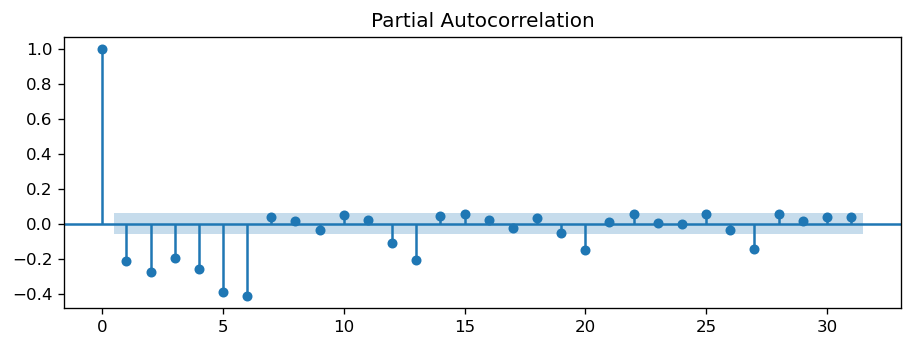

In [71]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.figure(figsize = (15,5))
plot_pacf(diario_est.cantidad_pasos)
plt.show()

#### Parametro "q" - (MA)

Para definir "q" utilizamos el grafico de autocorrelacion, que nos indica cuantos terminos de MA se requieren para eliminar cualquier autocorrelacion en la serie estacionaria.

Por el grafico definimos que q = 2

<Figure size 1800x600 with 0 Axes>

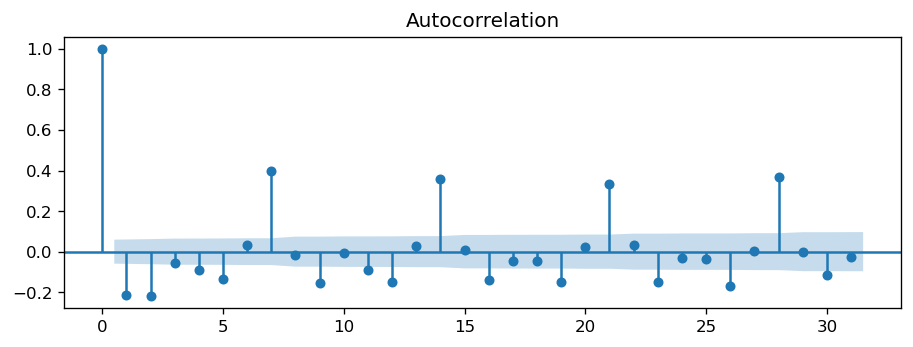

In [72]:
plt.figure(figsize = (15,5))
plot_acf(diario_est.cantidad_pasos)
plt.show()

In [73]:
# ARIMA(p,d,q)
# p=6 , d=1 , q=2
model_arima = ARIMA(diario.cantidad_pasos, order=(6,1,2))
model_arima_fit = model_arima.fit(disp=0)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -10927.449
Method:                       css-mle   S.D. of innovations           5262.242
Date:                Sat, 19 Feb 2022   AIC                          21874.899
Time:                        19:48:10   BIC                          21924.875
Sample:                             1   HQIC                         21893.810
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -16.3117     33.716     -0.484      0.629     -82.394      49.770
ar.L1.D.cantidad_pasos    -0.6849      0.070     -9.813      0.000      -0.822      -0.548
ar.L

Con los datos anteriores inferimos que los parametros que tengan valores de P > 0.05, no son relevantes para el modelo, por ende lo unico que le es relevante es el termino AR. El valor del AIC, que se utiliza como metrica del modelo, es de 21874.899

In [74]:
# Probamos quitando el termino AR (q = 0)
# p = 6 , d = 2, q = 0
model_arima_2 = ARIMA(diario.cantidad_pasos, order=(6,1,0))
model_arima_2_fit = model_arima_2.fit(disp=0)
print(model_arima_2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -10927.497
Method:                       css-mle   S.D. of innovations           5262.470
Date:                Sat, 19 Feb 2022   AIC                          21870.993
Time:                        19:48:12   BIC                          21910.974
Sample:                             1   HQIC                         21886.122
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -16.1651     33.467     -0.483      0.629     -81.759      49.429
ar.L1.D.cantidad_pasos    -0.6662      0.027    -24.352      0.000      -0.720      -0.613
ar.L

Cuanto menor es el valor del AIC, mejor el es modelo. Como 21870.993 < 21874.899, es ligeramente mejor. Utilizaremos este modelo de benchmark

## Benchmark (diario)

In [75]:
model_benchmark = ARIMA(diario.cantidad_pasos, order=(6,1,0))
model_benchmark_fit = model_benchmark.fit(disp=0)
fc, se, conf = model_benchmark_fit.forecast(92, alpha=0.05)

In [76]:
res_bench =  evaluar_modelo(fc, test_diario.cantidad_pasos, "Benchmark(diario)")

In [77]:
predicciones_diario = pd.Series(data=fc, index=test_diario.cantidad_pasos.index)

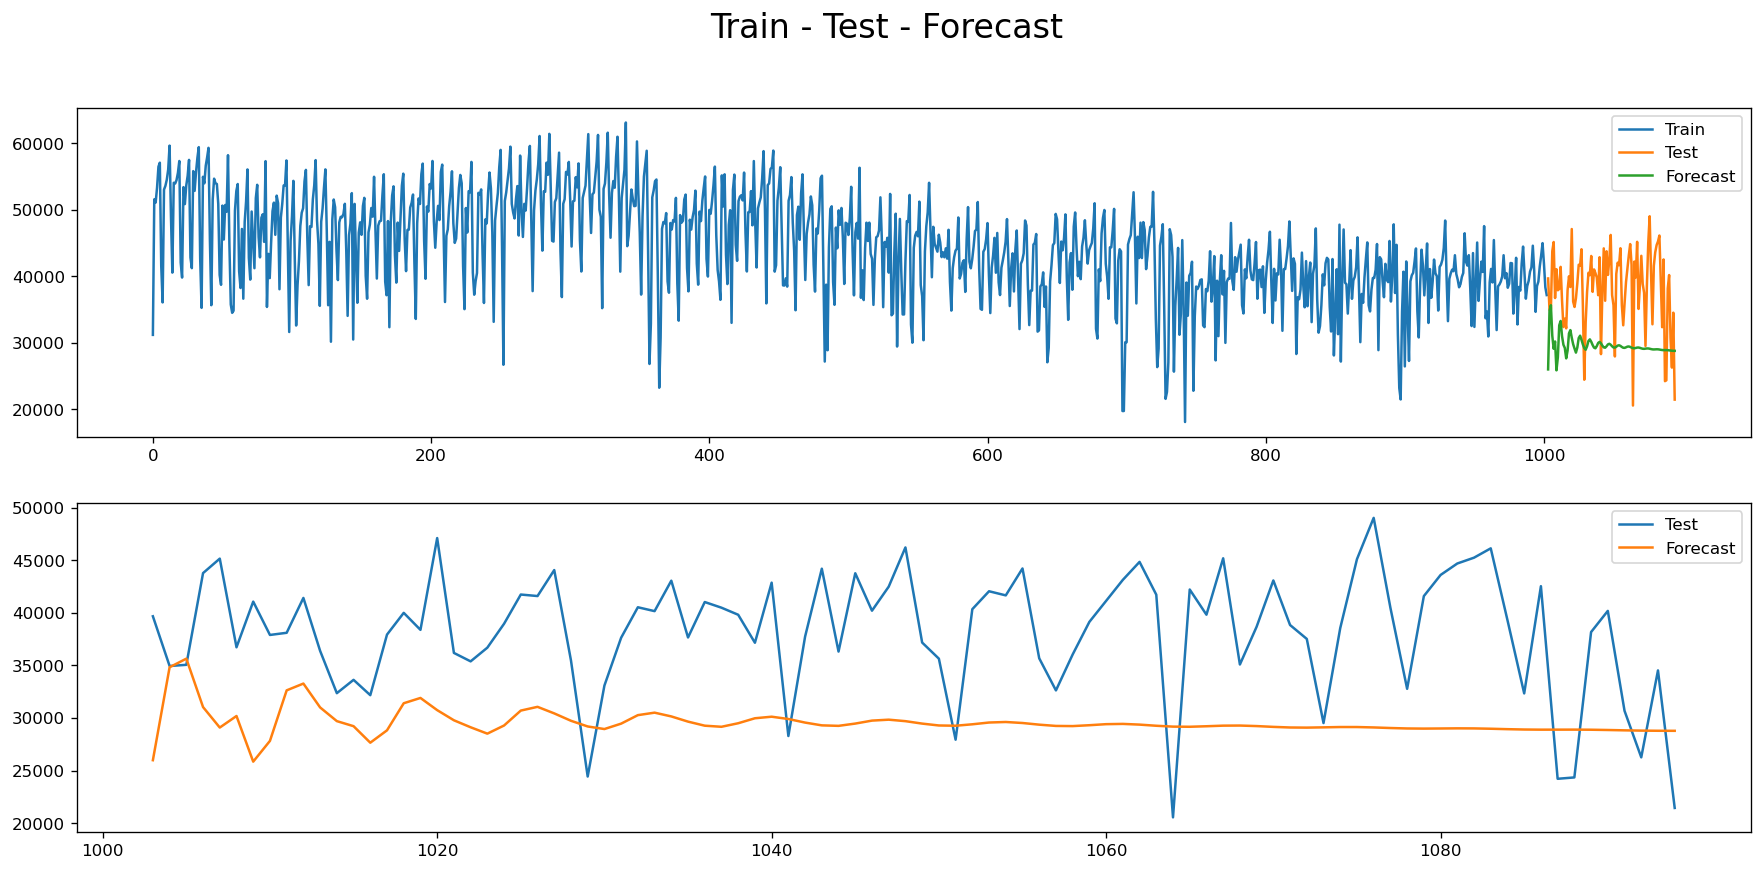

In [78]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_diario)

## AutoArima

(Optimizacion de hiperparametros)

### AutoArima (diario)

In [79]:
modelAA_diario = auto_arima(diario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)
print(modelAA_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22172.041, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22541.696, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22499.321, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22265.044, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22539.698, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22133.677, Time=0.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22417.361, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22124.778, Time=1.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22379.048, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22076.724, Time=0.56 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=22306.856, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=21993.755, Time=0.56 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=22131.155, Time=0.37 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=21914.003, Time=1.02 sec
 ARIMA(6,1,0)(0,0,0

In [80]:
# Best model:  ARIMA(9,1,4)(0,0,0)[0]
# Model:               SARIMAX(9, 1, 4)
modelAA_diario.fit(train_diario.cantidad_pasos)
train_diario.set_index('fecha', inplace=True)
test_diario.set_index('fecha', inplace=True)
pred_AA_diario = modelAA_diario.predict(n_periods=92, return_conf_int=False)
predicciones_AA_diario = pd.Series(data=pred_AA_diario, index=test_diario.cantidad_pasos.index)
predicciones_AA_diario.head()

fecha
2019-10-01    38749.844183
2019-10-02    39999.173626
2019-10-03    41864.875933
2019-10-04    43259.781038
2019-10-05    41181.893943
dtype: float64

In [81]:
autoarima_diario_res = evaluar_modelo(predicciones_AA_diario, test_diario.cantidad_pasos, "AutoArima Diario")
autoarima_diario_res

Modelo         RMSE
0  AutoArima Diario  5908.653283

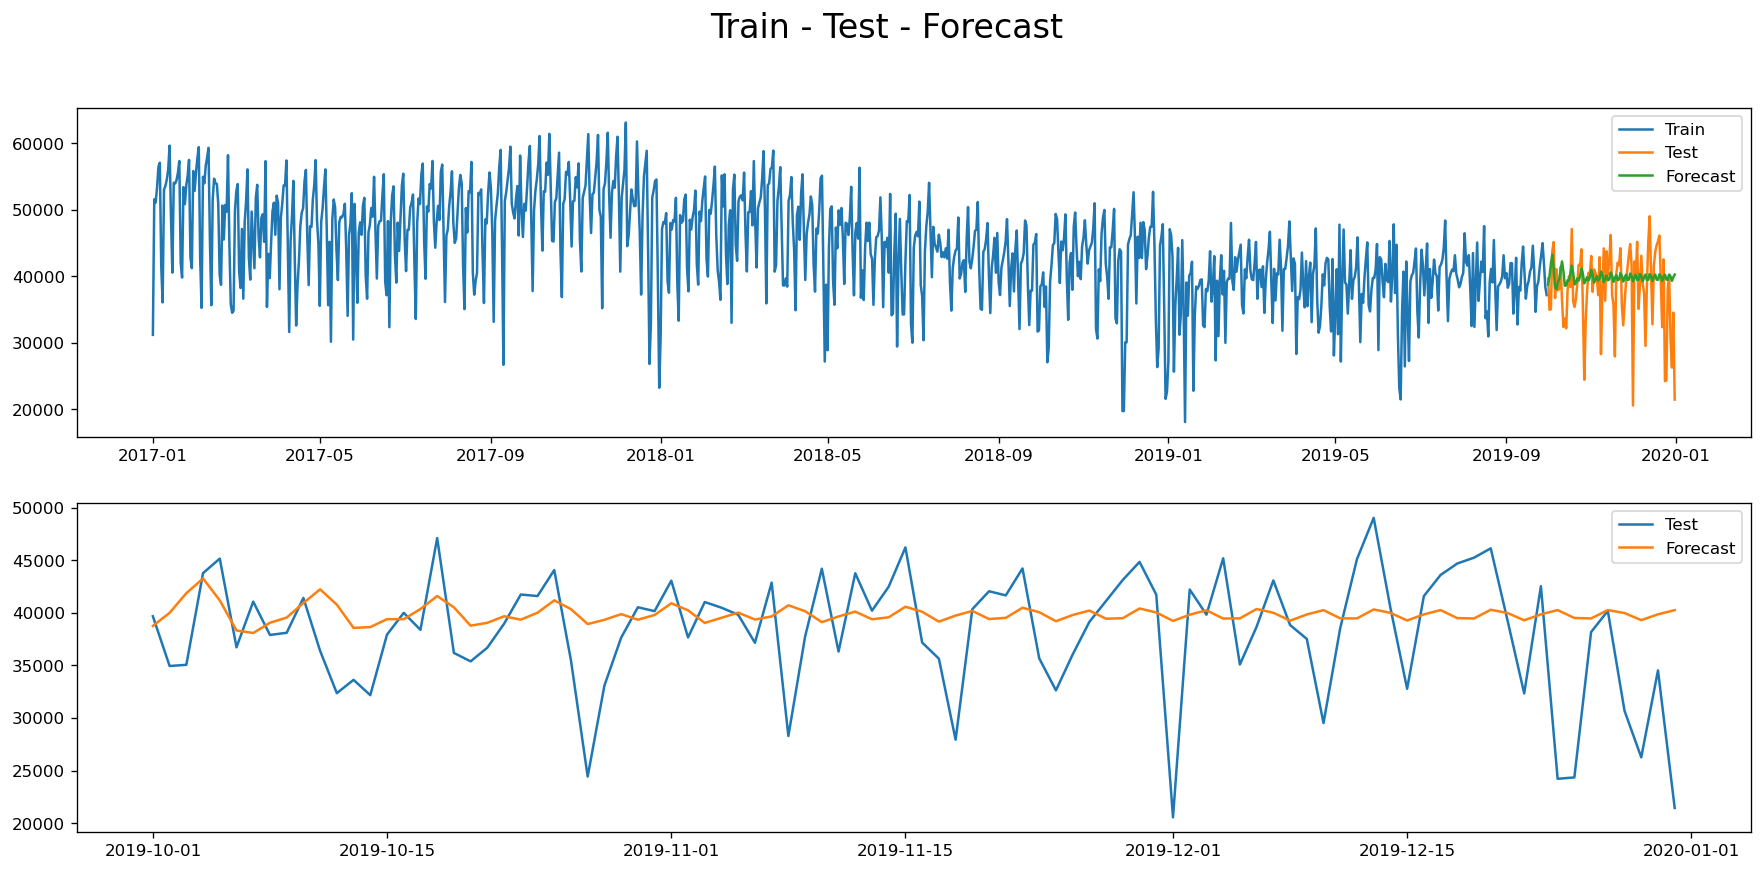

In [82]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AA_diario)

### AutoArima (semanal)

In [83]:
modelAA_semanal = auto_arima(semanal.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)
print(modelAA_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3558.709, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3558.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3555.418, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3556.276, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3556.557, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3558.197, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3557.512, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3553.482, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3556.056, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3556.162, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3553.970, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3556.751, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds
                               SARIMAX Results                                
Dep. Vari

In [84]:
# Best model:  ARIMA(1,1,0)(0,0,0)[0] 

modelAA_semanal.fit(train_semanal.cantidad_pasos)
train_semanal.set_index('fecha', inplace=True)
test_semanal.set_index('fecha', inplace=True)
pred_AA_semanal = modelAA_semanal.predict(n_periods=14, return_conf_int=False)
predicciones_AA_semanal = pd.Series(data=pred_AA_semanal, index=test_semanal.cantidad_pasos.index)
predicciones_AA_semanal.head()

fecha
2019-10-06    286804.898474
2019-10-13    286881.108909
2019-10-20    286873.497825
2019-10-27    286874.257939
2019-11-03    286874.182026
dtype: float64

In [85]:
autoarima_semanal_res = evaluar_modelo(predicciones_AA_semanal, test_semanal.cantidad_pasos, "AutoArima Semanal")
autoarima_semanal_res

Modelo          RMSE
0  AutoArima Semanal  27777.401686

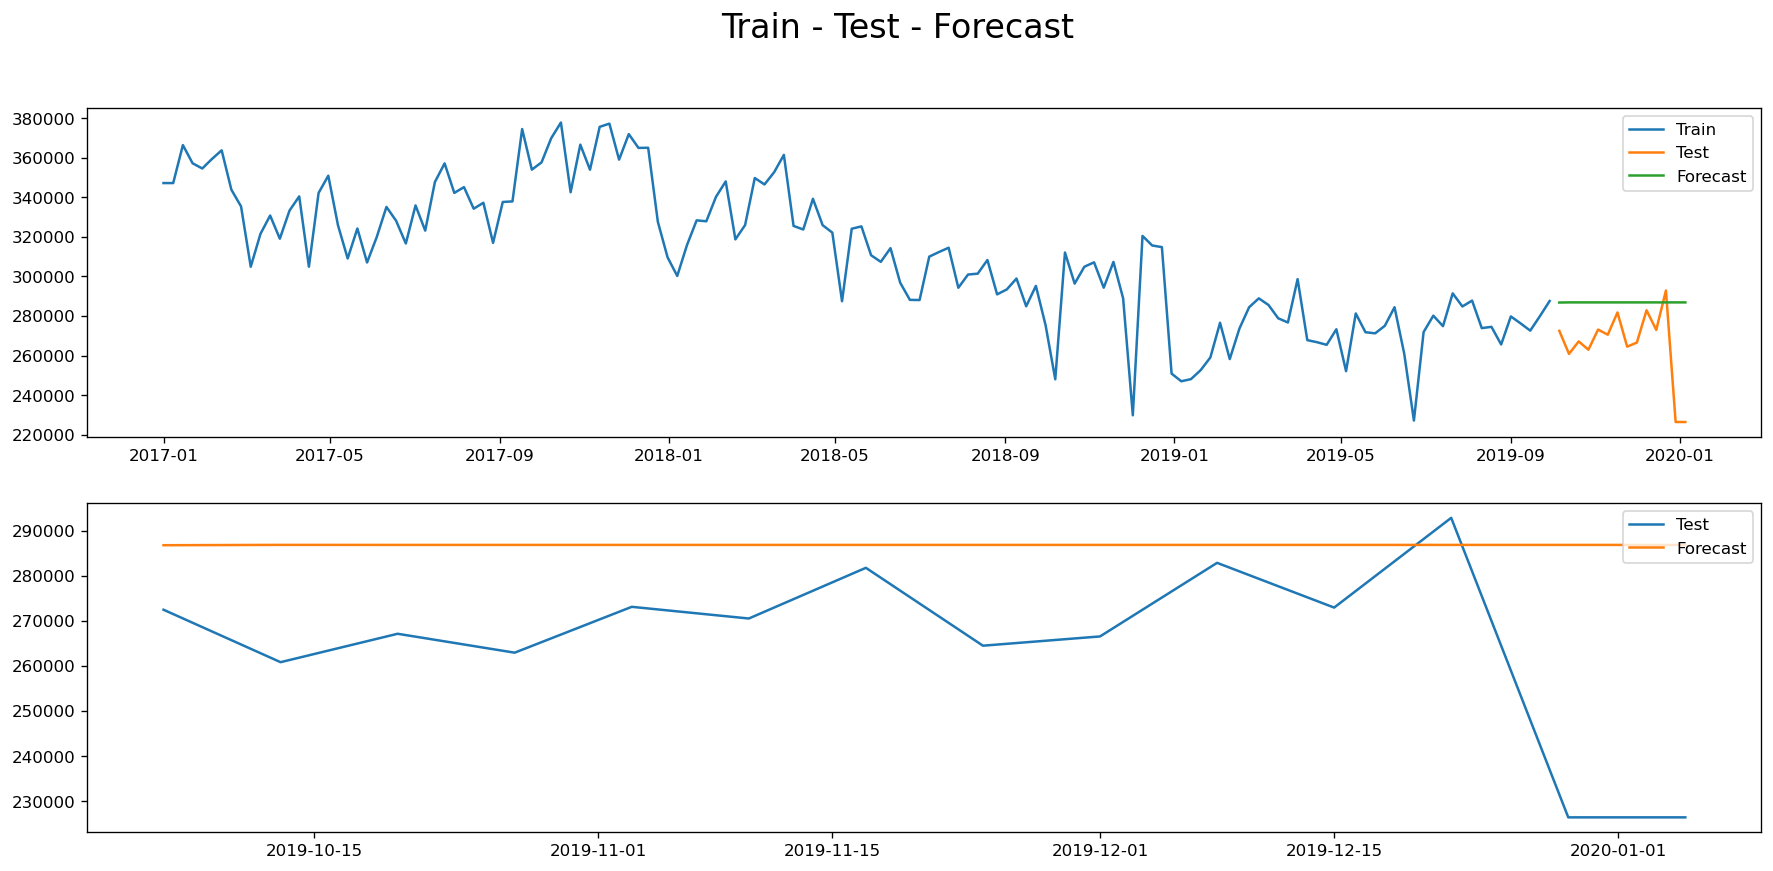

In [86]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AA_semanal)

## Prophet

### Prophet Diario

In [87]:
prophet_diario = pd.DataFrame({'ds':diario.fecha, 'y':diario.cantidad_pasos})


In [88]:
separacion = '2019-10-01'
prophet_fore = prophet_diario.loc[prophet_diario.ds <= separacion]
prophet_fore

ds        y
0    2017-01-01  31183.0
1    2017-01-02  51568.0
2    2017-01-03  51093.0
3    2017-01-04  53332.0
4    2017-01-05  56486.0
...         ...      ...
999  2019-09-27  44985.0
1000 2019-09-28  41925.0
1001 2019-09-29  38348.0
1002 2019-09-30  37170.0
1003 2019-10-01  39669.0

[1004 rows x 2 columns]

In [89]:
diario_datos_test = prophet_diario.loc[prophet_diario.ds >= separacion]
diario_datos_test

ds        y
1003 2019-10-01  39669.0
1004 2019-10-02  34943.0
1005 2019-10-03  35054.0
1006 2019-10-04  43775.0
1007 2019-10-05  45150.0
...         ...      ...
1090 2019-12-27  40182.0
1091 2019-12-28  30681.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  21447.0

[92 rows x 2 columns]

In [90]:
prophet_diario_model = Prophet(daily_seasonality=True)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=92, freq="D")
forecast = prophet_diario_model.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

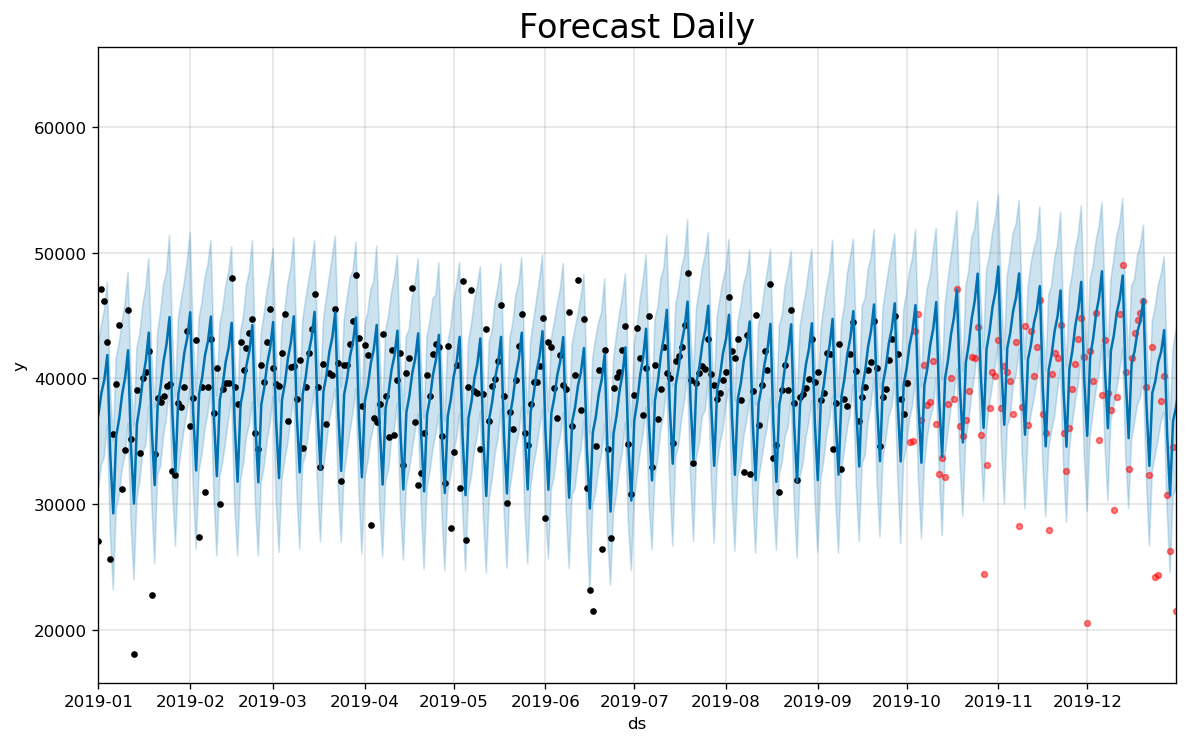

In [91]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [92]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds > separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")

#### Validación Cruzada y optimización de hiperparámetros

In [93]:
# initial= dias de entrenamiento, period= dias para hacer cross validation, horizon= dias usados como test)
df_cv = cross_validation(prophet_diario_model, initial='100 days', period='90 days', horizon="92 days")
df_cv

INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-04-12 00:00:00 and 2019-07-01 00:00:00
100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


ds          yhat    yhat_lower    yhat_upper        y     cutoff
0   2017-04-13  55323.974885  50116.324675  59892.472620  42650.0 2017-04-12
1   2017-04-14  56632.524961  51796.833452  61394.374436  32588.0 2017-04-12
2   2017-04-15  46289.906916  41353.002330  50905.768427  38688.0 2017-04-12
3   2017-04-16  40407.666266  35336.277019  45092.512741  42272.0 2017-04-12
4   2017-04-17  52840.175114  48054.451219  57798.184637  47573.0 2017-04-12
..         ...           ...           ...           ...      ...        ...
915 2019-09-27  45142.265551  38792.489301  51169.288968  44985.0 2019-07-01
916 2019-09-28  36661.232577  30656.999476  43374.423345  41925.0 2019-07-01
917 2019-09-29  31805.356005  25268.450233  37477.469181  38348.0 2019-07-01
918 2019-09-30  38476.452785  32425.130319  44215.406638  37170.0 2019-07-01
919 2019-10-01  39706.296572  33575.482983  46032.708434  39669.0 2019-07-01

[920 rows x 6 columns]

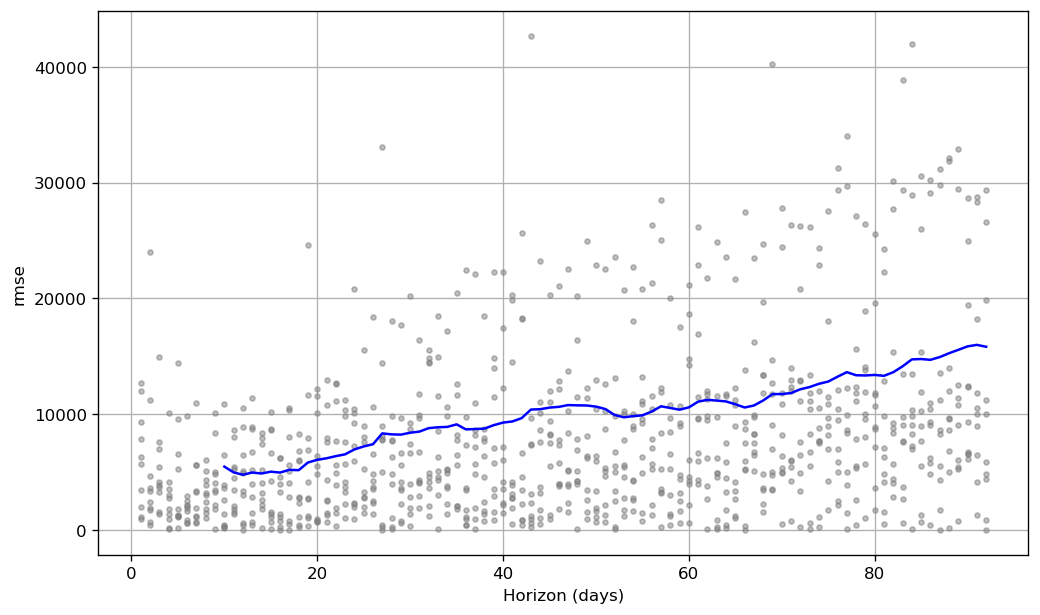

In [94]:
performance_cv = performance_metrics(df_cv)
plot = plot_cross_validation_metric(df_cv, metric='rmse')

In [95]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.1, 0.5, 0.7],
#     'seasonality_prior_scale': [0.001, 0.005,0.01,0.05],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params, daily_seasonality=True).fit(prophet_fore)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='92 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [96]:
# changepoint_prior_scale  seasonality_prior_scale         rmse
# 0                       0.1                    0.001  5990.489412
# 1                       0.1                    0.005  5361.603844
# 2                       0.1                    0.010  5819.837729
# 3                       0.1                    0.050  6892.071339
# 4                       0.5                    0.001  6456.042594
# 5                       0.5                    0.005  5929.729898
# 6                       0.5                    0.010  5710.689918
# 7                       0.5                    0.050  6463.508779
# 8                       0.7                    0.001  6584.359953
# 9                       0.7                    0.005  6053.937734
# 10                      0.7                    0.010  5864.926946
# 11                      0.7                    0.050  6515.813779

In [97]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [98]:
best_params = {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005}

In [99]:
prophet_diario_model = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=92)
forecast = prophet_diario_model.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

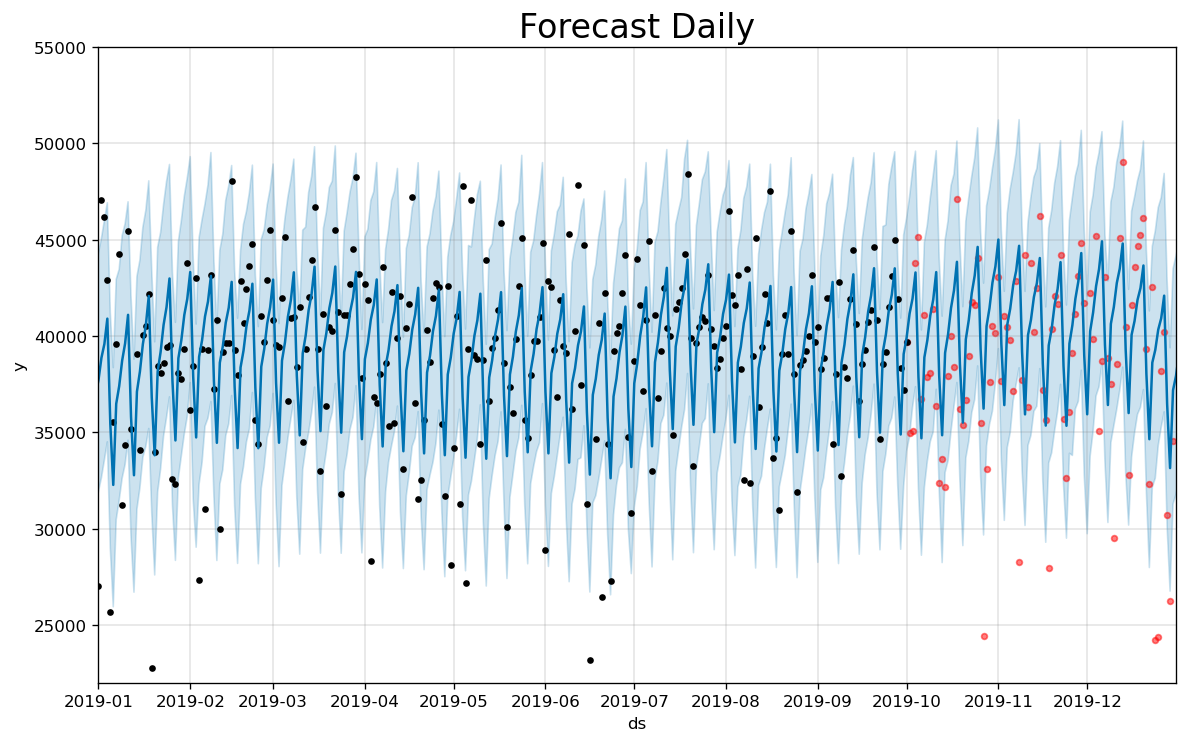

In [100]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(22000, 55000)
plt.title('Forecast Daily', fontsize=20)

In [101]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds > separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario_opt = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario CV/HP")
res_prophet_diario_opt

Modelo         RMSE
0  Prophet Diario CV/HP  6370.243612

## Prophet Semanal

In [102]:
prophet_semanal = pd.DataFrame({'ds':semanal.fecha, 'y':semanal.cantidad_pasos})
prophet_semanal

ds         y
0   2017-01-01  347212.0
1   2017-01-08  347212.0
2   2017-01-15  366413.0
3   2017-01-22  357215.0
4   2017-01-29  354581.0
..         ...       ...
153 2019-12-08  282891.0
154 2019-12-15  272960.0
155 2019-12-22  292881.0
156 2019-12-29  226390.0
157 2020-01-05  226390.0

[158 rows x 2 columns]

In [103]:
prophet_fore_s = prophet_semanal.loc[prophet_semanal.ds < separacion]
prophet_fore_s.tail()

ds         y
139 2019-09-01  279775.0
140 2019-09-08  276271.0
141 2019-09-15  272592.0
142 2019-09-22  279927.0
143 2019-09-29  287568.0

In [104]:
semanal_datos_test = prophet_semanal.loc[(prophet_semanal.ds > separacion) & (prophet_semanal.ds < "2020-01-05")]
semanal_datos_test

ds         y
144 2019-10-06  272483.0
145 2019-10-13  260840.0
146 2019-10-20  267147.0
147 2019-10-27  262950.0
148 2019-11-03  273129.0
149 2019-11-10  270536.0
150 2019-11-17  281790.0
151 2019-11-24  264500.0
152 2019-12-01  266555.0
153 2019-12-08  282891.0
154 2019-12-15  272960.0
155 2019-12-22  292881.0
156 2019-12-29  226390.0

In [105]:
prophet_semanal_model = Prophet(weekly_seasonality=True)
prophet_semanal_model.fit(prophet_fore_s)
pred_prophet = prophet_semanal_model.make_future_dataframe(periods=14, freq="W")
forecast = prophet_semanal_model.predict(pred_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [106]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds           yhat     yhat_lower     yhat_upper
0   2017-01-01  333151.327463  313911.834636  354877.940938
1   2017-01-08  324979.055030  303415.275422  343671.694808
2   2017-01-15  329586.282185  308892.806070  349489.734014
3   2017-01-22  340810.962091  321982.843494  360890.801859
4   2017-01-29  349504.110690  329650.688453  369534.281946
..         ...            ...            ...            ...
153 2019-12-08  293743.585884  274198.384056  313218.951765
154 2019-12-15  295082.003917  275664.155152  315854.646893
155 2019-12-22  284150.132662  263973.512720  304833.183272
156 2019-12-29  265737.044953  245705.801526  285554.496411
157 2020-01-05  251427.524551  230662.652318  271773.912658

[158 rows x 4 columns]

Text(0.5, 1.0, 'Forecast Weekly')

<Figure size 1440x360 with 0 Axes>

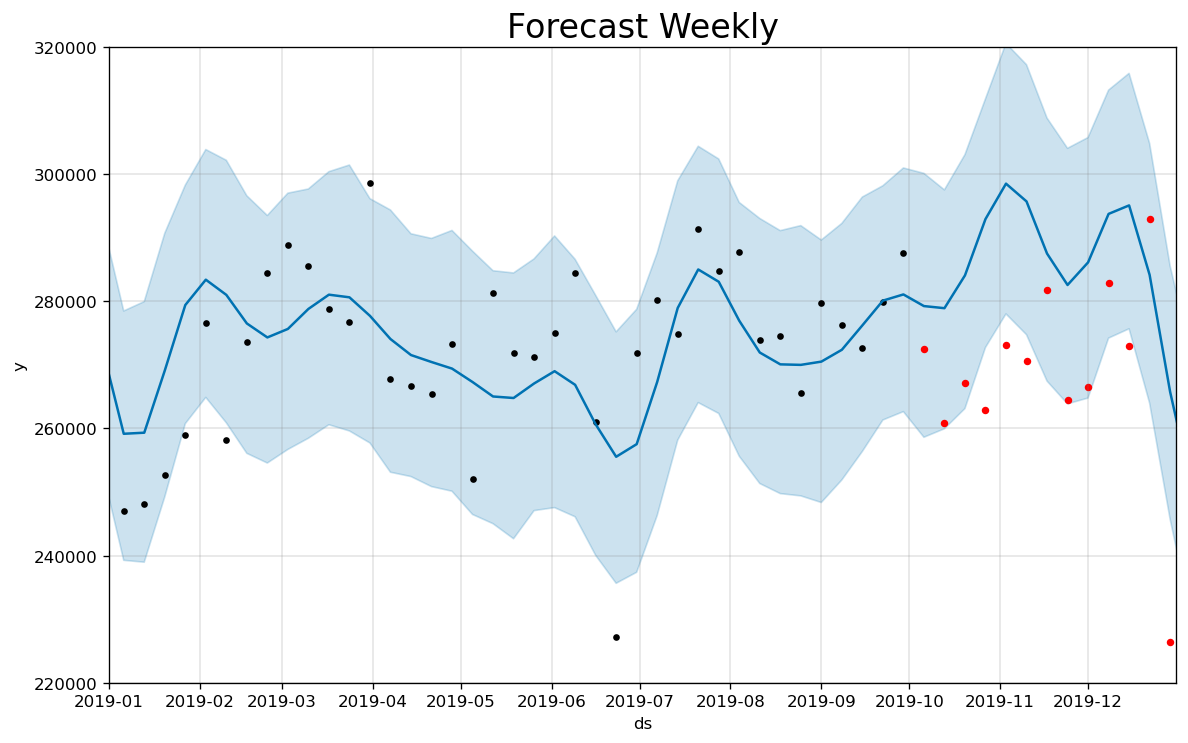

In [107]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal_model.plot(forecast)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=12)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(220000,320000)
plt.title('Forecast Weekly', fontsize=20)

In [108]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds > separacion) & (forecast.ds < "2020-01-05")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_sem = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal")
res_prophet_sem

Modelo          RMSE
0  Prophet Semanal  21136.585021

#### Validación Cruzada y optimización de hiperparámetros

In [109]:
# initial= dias de entrenamiento, period= dias para hacer cross validation, horizon= dias usados como test), siendo el total 1095
df_cv_sem = cross_validation(prophet_semanal_model, initial='500 days', period='90 days', horizon="92 days")
df_cv_sem

INFO:fbprophet:Making 5 forecasts with cutoffs between 2018-07-04 00:00:00 and 2019-06-29 00:00:00
100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


ds           yhat     yhat_lower     yhat_upper         y  \
0  2018-07-08  315108.684610  298704.322139  332504.335316  310012.0   
1  2018-07-15  330086.223300  313640.438687  346578.751149  312335.0   
2  2018-07-22  339701.475224  322748.143681  355736.290720  314517.0   
3  2018-07-29  339890.323248  321405.420302  356487.213785  294270.0   
4  2018-08-05  332806.979869  316492.223137  352201.470860  300955.0   
..        ...            ...            ...            ...       ...   
61 2019-09-01  248383.676633  228936.512045  270822.921445  279775.0   
62 2019-09-08  249408.888277  227368.760991  269524.579718  276271.0   
63 2019-09-15  252222.905803  232164.294521  273597.261766  272592.0   
64 2019-09-22  255426.714005  234130.720368  276285.330386  279927.0   
65 2019-09-29  256030.757094  235553.067061  277617.224999  287568.0   

       cutoff  
0  2018-07-04  
1  2018-07-04  
2  2018-07-04  
3  2018-07-04  
4  2018-07-04  
..        ...  
61 2019-06-29  
62 2019-06-29  
63 2019-06-29  
64 2019-06-29  
65 2019-06-29  

[66 rows x 6 columns]

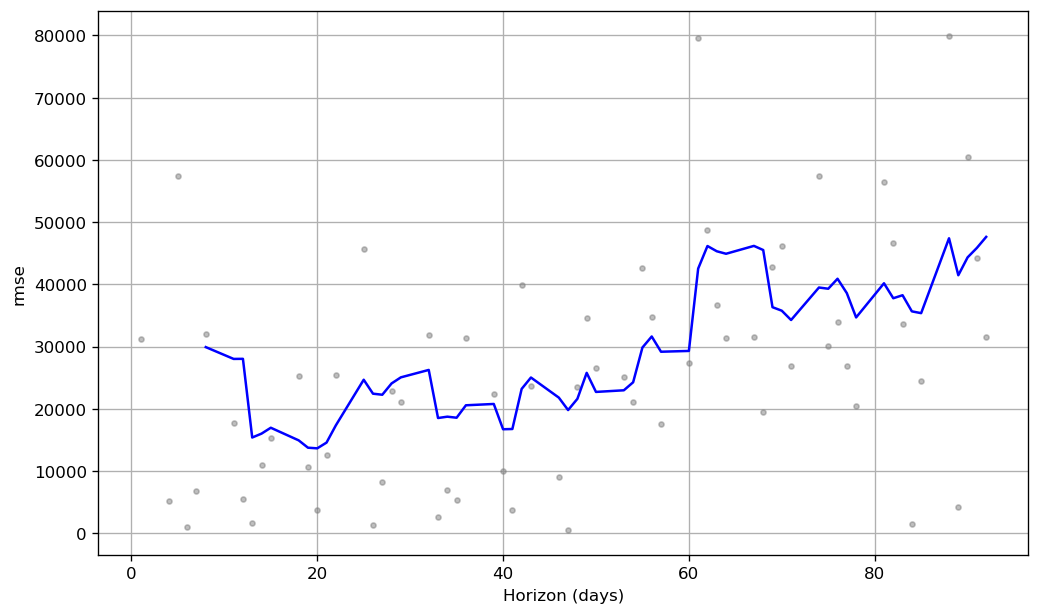

In [110]:
performance_cv_sem = performance_metrics(df_cv_sem)
plot = plot_cross_validation_metric(df_cv_sem, metric='rmse')

In [111]:
# # Python
# import itertools
# import numpy as np
# import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.1, 0.5, 1, 10],
#     'seasonality_prior_scale': [0.001, 0.1, 1 ,10],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params, weekly_seasonality=True).fit(prophet_fore_s)  # Fit model with given params
#     df_cv_sem = cross_validation(m, horizon='92 days', parallel="processes")
#     df_p = performance_metrics(df_cv_sem, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [112]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [113]:
best_params = {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.001}

In [114]:
prophet_semanal_model = Prophet(**best_params, weekly_seasonality=True)
prophet_semanal_model.fit(prophet_fore_s)
pred_prophet = prophet_semanal_model.make_future_dataframe(periods=14, freq="W")
forecast = prophet_semanal_model.predict(pred_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

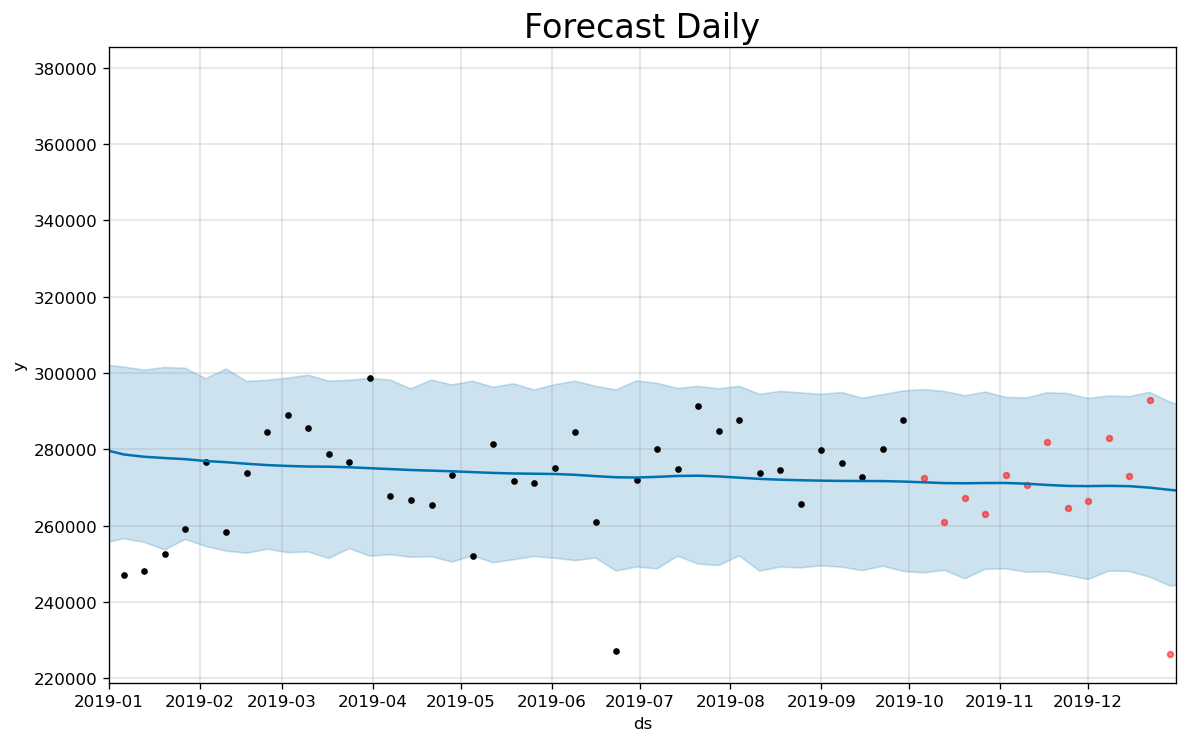

In [115]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal_model.plot(forecast)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [116]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds > separacion) & (forecast.ds < "2020-01-05")]
y_true = semanal_datos_test[['ds', 'y']]

res_prophet_semanal_opt = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal CV/HP")
res_prophet_semanal_opt

Modelo          RMSE
0  Prophet Semanal CV/HP  14939.485763

## Resultados 

In [117]:
res_finales = pd.concat([res_bench,
                        autoarima_diario_res, res_prophet_diario, res_prophet_diario_opt,
                        autoarima_semanal_res, res_prophet_sem, res_prophet_semanal_opt
                         ])
res_finales.reset_index(drop=True)

Modelo          RMSE
0      Benchmark(diario)  10418.495649
1       AutoArima Diario   5908.653283
2         Prophet Diario   7445.332357
3   Prophet Diario CV/HP   6370.243612
4      AutoArima Semanal  27777.401686
5        Prophet Semanal  21136.585021
6  Prophet Semanal CV/HP  14939.485763

Si bien el modelo de prediccion diaria con menor RMSE es el de "AutoArima Diario", el modelo de "Prophet Diario CV/HP" termina siendo la mejor elección porque en este se realizó validacion cruzada, lo que garantiza que no habra sobreajuste en el modelo, y por lo pequeña diferencia entre los modelos vale la pena escoger este último.

Para el caso de los modelos de predicción semanal el mejor modelo es el de "Prophet Semanal CV/HP", por los mismos motivos que el anterior y por tener el menor RMSE.

# Prediccion 2020

In [118]:
data_2020 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2020.csv', sep =',')

In [119]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

data_2020

fecha        mes        dia  dia_fecha  hora_fin  \
52       2020-01-01 00:00:00      enero  Miércoles        1.0       1.0   
53       2020-01-01 00:00:00      enero  Miércoles        1.0       1.0   
134      2020-01-01 00:00:00      enero  Miércoles        1.0       2.0   
135      2020-01-01 00:00:00      enero  Miércoles        1.0       2.0   
202      2020-01-01 00:00:00      enero  Miércoles        1.0       3.0   
...                      ...        ...        ...        ...       ...   
2532216           2020-12-24  diciembre     Jueves       24.0      12.0   
2532227           2020-12-24  diciembre     Jueves       24.0      13.0   
2532271           2020-12-24  diciembre     Jueves       24.0      18.0   
2532928           2020-12-28  diciembre      Lunes       28.0      13.0   
2533497           2020-12-30  diciembre  Miércoles       30.0      14.0   

          tipo_vehiculo observacion    sentido  cantidad_pasos  
52                 Auto    Efectivo     Centro           326.0  
53                 Auto    Efectivo  Provincia           319.0  
134                Auto    Efectivo     Centro           199.0  
135                Auto    Efectivo  Provincia           180.0  
202                Auto    Efectivo     Centro           114.0  
...                 ...         ...        ...             ...  
2532216  Pesados 6 Ejes    Efectivo  Provincia             1.0  
2532227  Pesados 6 Ejes    Efectivo  Provincia             1.0  
2532271  Pesados 6 Ejes    Efectivo     Centro             1.0  
2532928  Pesados 6 Ejes    Efectivo  Provincia             1.0  
2533497  Pesados 6 Ejes    Efectivo  Provincia             4.0  

[52374 rows x 9 columns]

In [120]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Reordenamos el dataset por fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
data_2020 = data_2020.resample('D', on = 'fecha').sum()

In [121]:
data_2020.rename(columns = {"dia_fecha": "fecha"}, inplace=True)
data_2020.drop(columns="fecha", inplace=True)
data_2020.reset_index(inplace=True)
data_2020

fecha  cantidad_pasos
0   2020-01-01         21395.0
1   2020-01-02         33722.0
2   2020-01-03         37067.0
3   2020-01-04         30627.0
4   2020-01-05         27812.0
..         ...             ...
361 2020-12-27          8434.0
362 2020-12-28         10311.0
363 2020-12-29         12036.0
364 2020-12-30         12527.0
365 2020-12-31          6553.0

[366 rows x 2 columns]

In [122]:
diario

fecha  cantidad_pasos
0    2017-01-01         31183.0
1    2017-01-02         51568.0
2    2017-01-03         51093.0
3    2017-01-04         53332.0
4    2017-01-05         56486.0
...         ...             ...
1090 2019-12-27         40182.0
1091 2019-12-28         30681.0
1092 2019-12-29         26259.0
1093 2019-12-30         34523.0
1094 2019-12-31         21447.0

[1095 rows x 2 columns]

In [123]:
dataset_2020 = pd.concat([diario, data_2020])

In [124]:
dataset_2020

fecha  cantidad_pasos
0   2017-01-01         31183.0
1   2017-01-02         51568.0
2   2017-01-03         51093.0
3   2017-01-04         53332.0
4   2017-01-05         56486.0
..         ...             ...
361 2020-12-27          8434.0
362 2020-12-28         10311.0
363 2020-12-29         12036.0
364 2020-12-30         12527.0
365 2020-12-31          6553.0

[1461 rows x 2 columns]

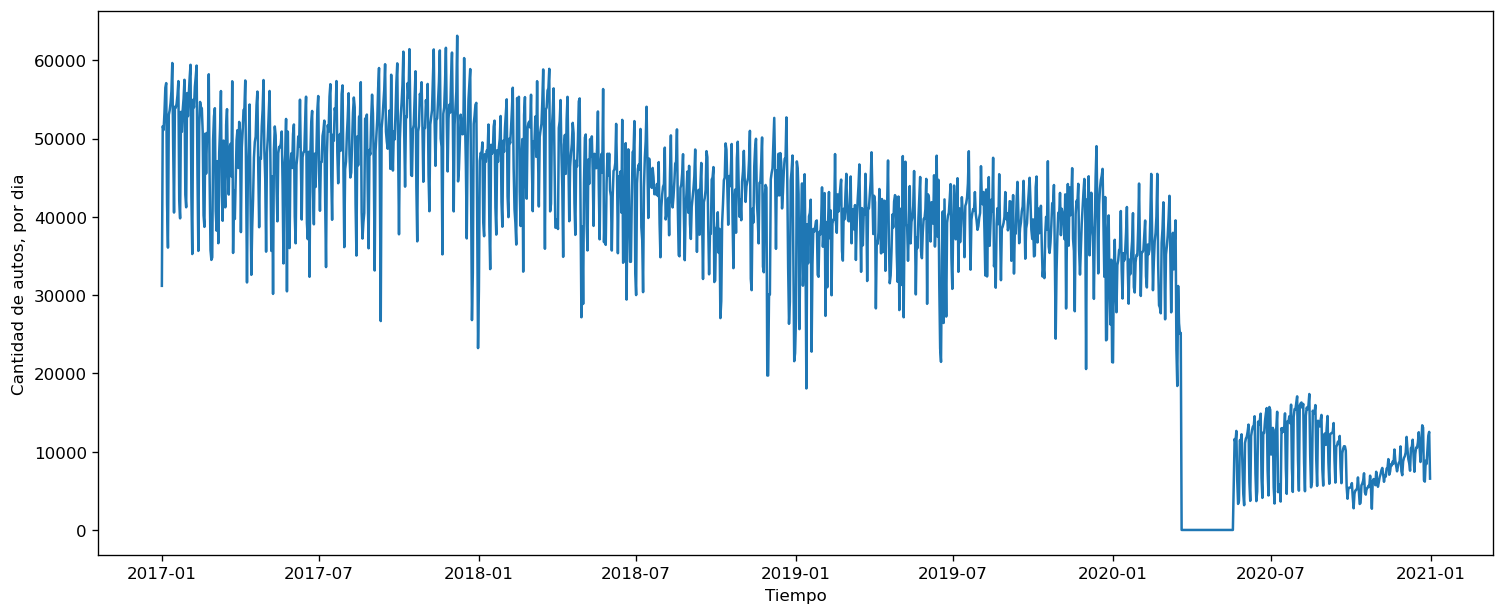

In [125]:
plt.figure(figsize = (15,6))
plt.plot(dataset_2020.fecha, dataset_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [126]:
dataset_2020 = pd.DataFrame({'ds':dataset_2020.fecha, 'y':dataset_2020.cantidad_pasos})
separacion = '2020-01-01'
prophet_fore = dataset_2020.loc[dataset_2020.ds <= separacion]
diario_datos_test = dataset_2020.loc[dataset_2020.ds >= separacion]

In [127]:
best_params = {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005}
prophet_diario_model = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=365)
forecast = prophet_diario_model.predict(pred_prophet)

In [128]:
dataset_2020

ds        y
0   2017-01-01  31183.0
1   2017-01-02  51568.0
2   2017-01-03  51093.0
3   2017-01-04  53332.0
4   2017-01-05  56486.0
..         ...      ...
361 2020-12-27   8434.0
362 2020-12-28  10311.0
363 2020-12-29  12036.0
364 2020-12-30  12527.0
365 2020-12-31   6553.0

[1461 rows x 2 columns]

In [129]:
forecast[['ds', 'yhat']].loc[forecast.ds > separacion]

ds          yhat
1096 2020-01-02  36940.098185
1097 2020-01-03  38252.226409
1098 2020-01-04  32873.326238
1099 2020-01-05  29640.867289
1100 2020-01-06  33807.620150
...         ...           ...
1456 2020-12-27  28213.912399
1457 2020-12-28  32137.776529
1458 2020-12-29  32727.167097
1459 2020-12-30  33811.513275
1460 2020-12-31  34581.317486

[365 rows x 2 columns]

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

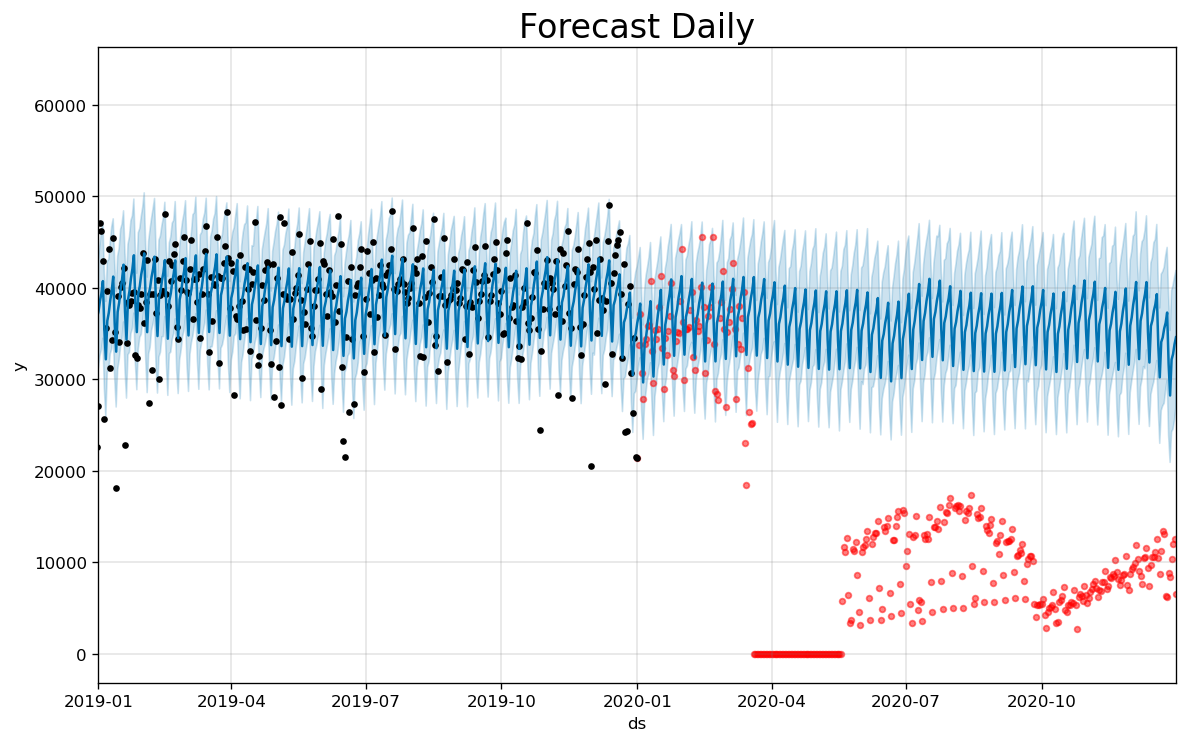

In [130]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2020-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [131]:
y_pred = forecast[['ds', 'yhat']].loc[forecast.ds >= separacion]
y_true = diario_datos_test[['ds', 'y']]


res_2020 = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")
res_2020

Modelo          RMSE
0  Prophet Diario  25812.137273

El modelo funciona de manera similar a los casos anteriores hasta que sucede la pandemia del COVID-19 y el error pasa a ser demasiado grande.

# Utilizando los años 2014 / 2015 / 2016

In [132]:
data_2014 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2014.csv', sep =',')


## 2016

In [133]:
data_2016 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2016.csv', sep =',')
data_2016.head(1)

periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2016  2016-01-01            0         1  Viernes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              32

In [134]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2016.estacion=='Illia', data_2016.forma_pago == 'EFECTIVO')
data_2016 = data_2016[mask]

#Quitamos las columnas que no vamos a utilizar
data_2016.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2016['fecha2'] = pd.to_datetime(data_2016.fecha) + pd.to_timedelta(data_2016.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2016.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2016.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_2016 = data_2016.resample('D', on = 'fecha').sum()
print(diario_2016.shape)

diario_2016.head()

(366, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907

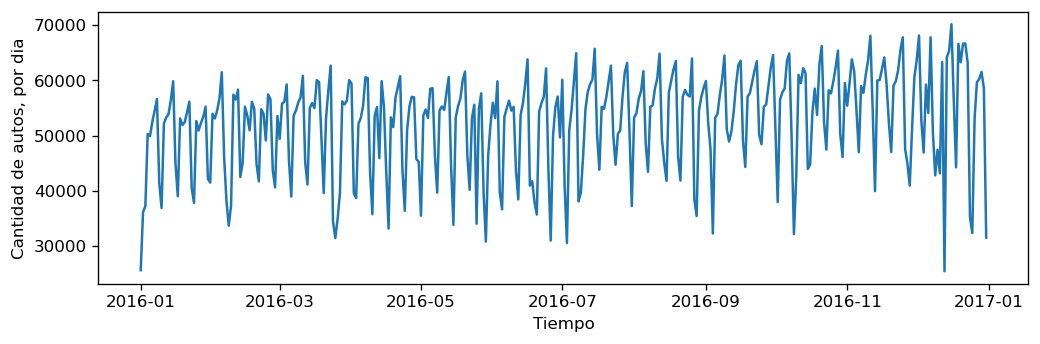

In [135]:
plt.figure(figsize = (10,3))
plt.plot(diario_2016.index, diario_2016.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Text(0.5, 1.0, 'Boxplot de cantidad de pasos diarios')

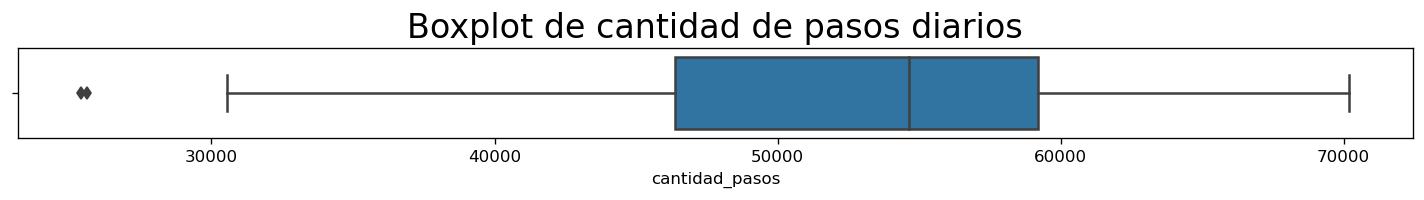

In [136]:
plt.figure(figsize=(15,1))
sns.boxplot(diario_2016.cantidad_pasos)
plt.title("Boxplot de cantidad de pasos diarios", fontsize=20)

In [137]:
diario_2016[diario_2016.cantidad_pasos < 30000] = np.nan
print(diario_2016.isna().sum())
diario_2016.interpolate(method="nearest", inplace=True)
diario_2016.cantidad_pasos.fillna(value=36136, inplace=True)
print(diario_2016.isna().sum())


cantidad_pasos    2
dtype: int64
cantidad_pasos    0
dtype: int64


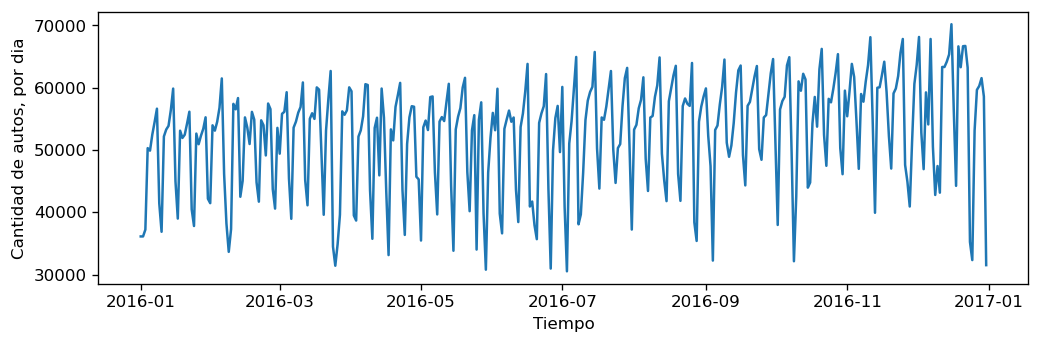

In [138]:
plt.figure(figsize = (10,3))
plt.plot(diario_2016.index, diario_2016.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [139]:
# Verificamos que la serie de tiempo este completa:
(diario_2016.index == pd.date_range(start=diario_2016.index.min(), end=diario_2016.index.max(), freq=diario_2016.index.freq)).all()

True

## 2015

In [140]:
data_2015 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2015.csv', sep =',')
data_2015.head(1)

periodo       fecha  hora     dia estacion tipo_vehiculo  forma_pago  \
0     2015  2015-01-01     0  Jueves  Alberdi       Liviano  NO COBRADO   

   cantidad_pasos  
0              15

In [141]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2015.estacion=='Illia', data_2015.forma_pago == 'EFECTIVO')
data_2015 = data_2015[mask]

#Quitamos las columnas que no vamos a utilizar
data_2015.drop(columns = ['periodo','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2015['fecha2'] = pd.to_datetime(data_2015.fecha) + pd.to_timedelta(data_2015.hora, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2015.drop(columns=['fecha','hora'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2015.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_2015 = data_2015.resample('D', on = 'fecha').sum()
print(diario_2015.shape)

diario_2015.head()

(365, 1)


cantidad_pasos
fecha                     
2015-01-01           25697
2015-01-02           38112
2015-01-03           27601
2015-01-04           33803
2015-01-05           48683

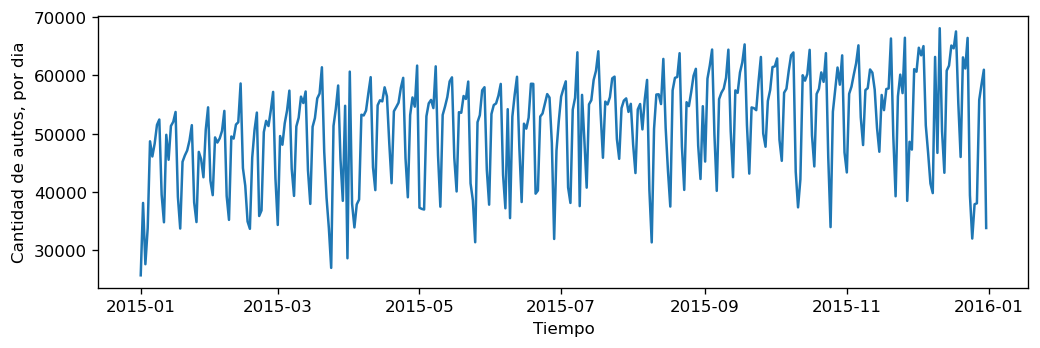

In [142]:
plt.figure(figsize = (10,3))
plt.plot(diario_2015.index, diario_2015.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Text(0.5, 1.0, 'Boxplot de cantidad de pasos diarios')

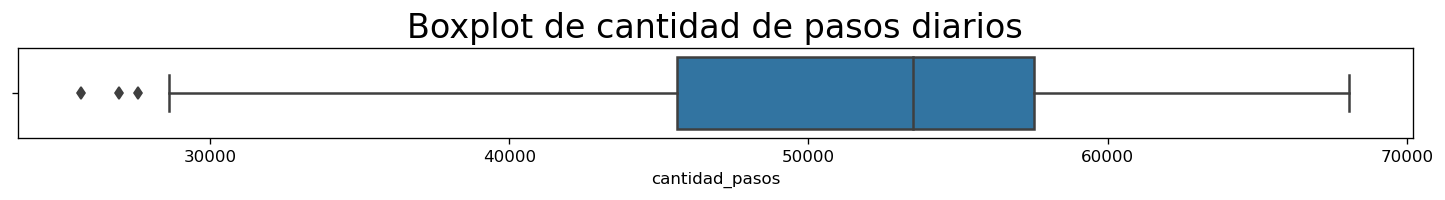

In [143]:
plt.figure(figsize=(15,1))
sns.boxplot(diario_2015.cantidad_pasos)
plt.title("Boxplot de cantidad de pasos diarios", fontsize=20)

In [144]:
diario_2015[diario_2015.cantidad_pasos < 28000] = np.nan
print(diario_2015.isna().sum())
diario_2015.interpolate(method="nearest", inplace=True)
diario_2015.cantidad_pasos.fillna(value=38112, inplace=True)
print(diario_2015.isna().sum())

cantidad_pasos    3
dtype: int64
cantidad_pasos    0
dtype: int64


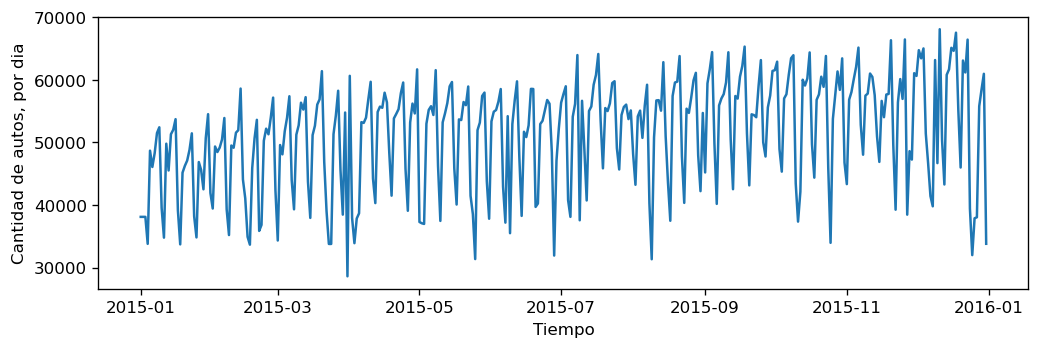

In [145]:
plt.figure(figsize = (10,3))
plt.plot(diario_2015.index, diario_2015.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [146]:
# Verificamos que la serie de tiempo este completa:
(diario_2015.index == pd.date_range(start=diario_2015.index.min(), end=diario_2015.index.max(), freq=diario_2015.index.freq)).all()

True

## 2014

In [147]:
data_2014 = pd.read_csv(r'A:\DATA SCIENCE\01-PROYECTOS\Sprint 3 - Series de Tiempo\datasets\flujo-vehicular-2014.csv', sep =',')
data_2014.head(1)

periodo       fecha  hora        dia estacion tipo_vehiculo  forma_pago  \
0   2014.0  2014-01-01   0.0  Miercoles  Alberdi       Liviano  NO COBRADO   

   cantidad_pasos  
0            26.0

In [148]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2014.estacion=='Illia', data_2014.forma_pago == 'EFECTIVO')
data_2014 = data_2014[mask]

#Quitamos las columnas que no vamos a utilizar
data_2014.drop(columns = ['periodo','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2014['fecha2'] = pd.to_datetime(data_2014.fecha) + pd.to_timedelta(data_2014.hora, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2014.drop(columns=['fecha','hora'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2014.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_2014 = data_2014.resample('D', on = 'fecha').sum()
print(diario_2015.shape)

diario_2014.head()

(365, 1)


cantidad_pasos
fecha                     
2014-01-01          7979.0
2014-01-02         18024.0
2014-01-03         35995.0
2014-01-04             1.0
2014-01-05             1.0

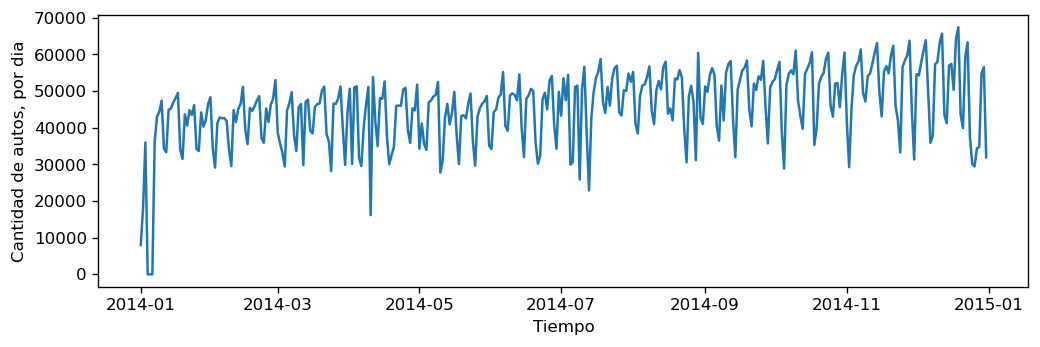

In [149]:
plt.figure(figsize = (10,3))
plt.plot(diario_2014.index, diario_2014.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Text(0.5, 1.0, 'Boxplot de cantidad de pasos diarios')

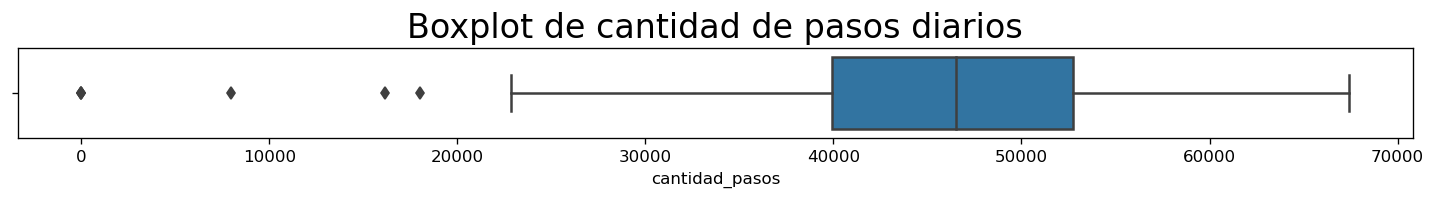

In [150]:
plt.figure(figsize=(15,1))
sns.boxplot(diario_2014.cantidad_pasos)
plt.title("Boxplot de cantidad de pasos diarios", fontsize=20)

In [151]:
diario_2014[diario_2014.cantidad_pasos < 20000] = np.nan
print(diario_2014.isna().sum())
diario_2014.interpolate(method="linear", inplace=True)
diario_2014.cantidad_pasos.fillna(value=35995.00, inplace=True)
print(diario_2014.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


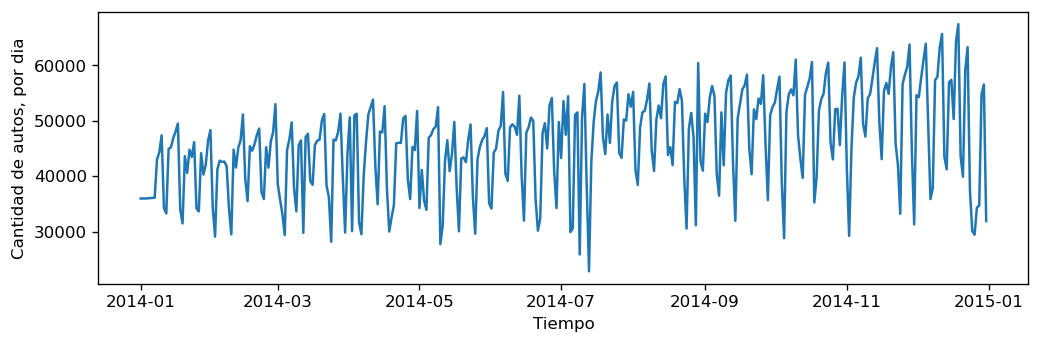

In [152]:
plt.figure(figsize = (10,3))
plt.plot(diario_2014.index, diario_2014.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [153]:
# Verificamos que la serie de tiempo este completa:
(diario_2014.index == pd.date_range(start=diario_2014.index.min(), end=diario_2014.index.max(), freq=diario_2014.index.freq)).all()

True

## Union

In [154]:
diario.set_index("fecha", inplace=True)

In [155]:
dataset_final = pd.concat([diario_2014, diario_2015, diario_2016, diario])

In [156]:
dataset_final

cantidad_pasos
fecha                     
2014-01-01        35995.00
2014-01-02        35995.00
2014-01-03        35995.00
2014-01-04        36029.75
2014-01-05        36064.50
...                    ...
2019-12-27        40182.00
2019-12-28        30681.00
2019-12-29        26259.00
2019-12-30        34523.00
2019-12-31        21447.00

[2191 rows x 1 columns]

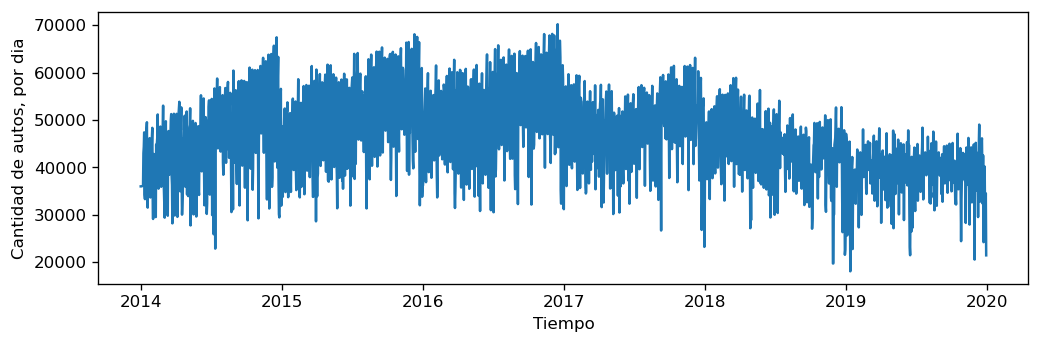

In [157]:
plt.figure(figsize = (10,3))
plt.plot(dataset_final.index, dataset_final.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### Modelo

In [158]:
dataset_final.reset_index(inplace=True)

In [159]:
prophet_diario_final = pd.DataFrame({'ds':dataset_final.fecha, 'y':dataset_final.cantidad_pasos})
separacion = '2019-10-01'
prophet_fore = prophet_diario_final.loc[prophet_diario_final.ds <= separacion]

In [160]:
diario_final_test = prophet_diario_final.loc[prophet_diario_final.ds >= separacion]

In [161]:
prophet_diario_final = Prophet(**best_params,daily_seasonality=True)
prophet_diario_final.fit(prophet_fore)
pred_prophet = prophet_diario_final.make_future_dataframe(periods=92, freq="D")
forecast = prophet_diario_final.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

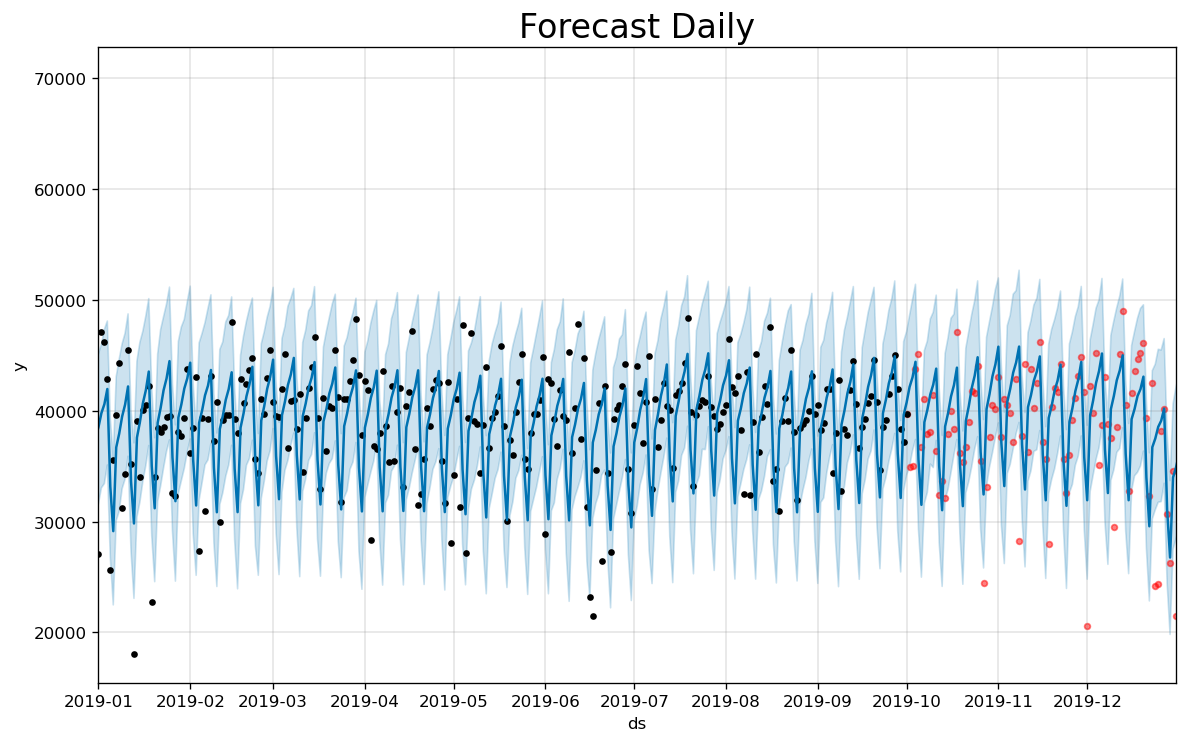

In [162]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_final.plot(forecast)
plt.scatter(diario_final_test.ds, diario_final_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [163]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds > separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_final_test[['ds', 'y']]


res_prophet_final = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")

In [164]:
res_prophet_final

Modelo         RMSE
0  Prophet Diario  6915.980807

El modelo no mejora al utlizar años anteriores, empeora ligeramente.

# Investigacion

Pregunta 1: ¿En la segunda mitad del 2021 se normalizo un poco mas el transito luego de la pandemia, podria ser mas acertada la prediccion para ese año?

El flujo de trabajo para responder esta pregunta seria basicamente el mismo que hicimos para predecir el año 2020: Quitar los outliers e imputarlos en la transformacion de datos, resamplear para que sea una serie de tiempo diaria, llevarlo al formato del modelo Prophet y optimizar sus hiperparametros.
La razon por la que esperamos que este modelo funcione mejor que el del 2020 es simplemente que ahora no vamos a tener interrumpciones abrutas debidas a la cuarentena.

Pregunta 2: ¿Como afecta al flujo vehicular la implementacion del metodo de pago "Telepase"?

Uno esperaria que al utilizar el Telepase, un metodo de pago automatico, el flujo vehicular por hora sea mayor. El flujo de trabajo para responder esto podria ser: Primero incorporar datos mas recientesy comparar por ejemplo en las horas pico donde mas trafico hay si el flujo vehicular (cantidad de pases/hora) es mayor. Incluso podria hacerse una estimacion de como crece la adopcion del Telepase y hacer una prediccion de como podria variar este flujo vehicular.